<< The Big Data Challenge 2019 >>

Author : Andy RK Chang & 陳宇修

Create Date : Jul 05, 2019

Modify Date : Aug 02, 2019

Version : 1.12.2 - 新增兩個stacking 模型

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pylab as plts 
import math
import glob
import os.path
from operator import mod
from scipy import stats
%matplotlib inline
import re

In [2]:
#a.drop([0],inplace = True)

In [3]:
#global variable definition and initial
myDriveFilePath = './raw_data/'
recipeGroup = ['G11','G15','G17','G19','G32','G34','G48','G49']
examFilePath = './exam_data/'

PTCcolor = ['purple','red','coral','saddlebrown','orange'
            ,'olive','limegreen','blue','cyan','yellow']
rgColumns = ['filename','groupid','eqpid','date','sno','PTCno','count','mean','std',
             'min','Q1','Q2','Q3','max','median', 'startT','endT']


## , 'start2max_time','stable_time','max2ned_time','totaltime'

#v1.08 add
dropColumns = ['filename','groupid','eqpid','PTCno','sno', 'date']

In [4]:
## Function Module

#get RecipeGroup File List function
def getRecipeGroupFileList(aRecipeGroup):
    aFileList = glob.glob(myDriveFilePath + aRecipeGroup + "/*.txt")
    return aFileList
#get exam file list function
def getExamFileList():
    aFileList = glob.glob(examFilePath + "*.txt")
    return aFileList
#get file attribute function
def getFileAttributeList(aFile, aTraining):
    
    aFileAttributeList = []
    
    #修改為正則表達式
    if aTraining == True :
        aFileAttributeList.append(aFile)
        aFileAttributeList.append(re.search( r'(G\d+)', aFile).group())
        aFileAttributeList.append(re.search( r'(AC\(\d+x\d+\))',
                                            aFile,flags=re.IGNORECASE).group())
        aFileAttributeList.append(re.search( r'(\d{7,8})', aFile).group())
        aFileAttributeList.append(re.search( r'(00\d{1,3})', aFile).group())
    else:
        aFileAttributeList.append(aFile)
        aFileAttributeList.append('Nan')
        aFileAttributeList.append('Nan')
        aFileAttributeList.append('Nan')
        aFileAttributeList.append('Nan')
        
    return aFileAttributeList

# read recipe Group file data function

def readRecipeGroupFile(aFileName):
    _interpolate = False
    
    if _interpolate == False:
        fp = pd.read_csv(aFileName,sep="\t")    # 這裡不能用 \s+ 會有錯誤,如:G15 -PTC4 中間多個空格
        fp = fp.drop([0])                       # drop defoF
        fp = fp.drop(columns=['Unnamed: ' + str(len(fp.columns)-1)])# drop nonname column
        fp = fp.apply(pd.to_numeric, errors='coerce')  # str to numeric
        fp = fp[fp != 0 ] #讓為 0值變成NaN
        fp = fp.interpolate() #相NaN做內插
    else:
        #  v1.11如果要做內插法 使用這個,但由於只能填補0值,效果一般, 可用可不用
        fp = pd.read_csv(aFileName,sep="\t")    # 這裡不能用 \s+ 會有錯誤,如:G15 -PTC4 中間多個空格
        fp = fp.drop([0])                       # drop defoF
        fp = fp.drop(columns=['Unnamed: ' + str(len(fp.columns)-1)])# drop nonname column
        fp = fp.apply(pd.to_numeric, errors='coerce')  # str to numeric
        fp = fp[fp != 0 ] #讓為 0值變成NaN
        fp = fp.interpolate() #相NaN做內插
    
    return fp

def readExamFile(aFileName):
    fp = pd.read_csv(aFileName, sep = '\s+')
    fp = fp.drop([0])
    fp = fp.apply(pd.to_numeric, errors = 'coerce')
    
    return fp

#plot 成化曲線

def plotRecipeGroupFileCurve(aDf,aRG,aFN):
    
    #Draw Plot
    plt.figure(figsize = (10,8), dpi = 160)
    fig , ax = plt.subplots()
    
    ranges =  np.arange(len(aDf.columns))
    
    for i in ranges:
        aPTCno = aDf.columns[i].strip()
        aPTCno = aPTCno[aPTCno.find('PTC')+3: len(aPTCno)] #問題
        ax.plot(aDf.columns[i], data = aDf, color = PTCcolor[mod(int(aPTCno),10)],label=aDf.columns[i].strip())
        ax.axis([0,400,0,400])
        ax.set_title('recipe Group' + aRG + ' ; File No : ' + aFN, fontsize = 12, color = 'r')
    plt.legend()



# (*)Main()

In [5]:
_plogFlag = False
_plotFlag = False
_plotRecipeGroup = 7

rgdf = pd.DataFrame(columns = rgColumns)
                    
for i in range(len(recipeGroup)):
    
    aRecipeGroupFileList = getRecipeGroupFileList(recipeGroup[i])
    
    
    for j in range(len(aRecipeGroupFileList)):
                    
        df = readRecipeGroupFile(aRecipeGroupFileList[j])
                    
        for k in range(len(df.columns)):
            
            aFileAttributeList = getFileAttributeList(os.path.basename(aRecipeGroupFileList[j]), True)      
            aPTCno = df.columns[k].strip()
            aFileAttributeList.append(aPTCno[aPTCno.find('PTC'): len(aPTCno)])
            #6. PTCno
            aFileAttributeList.append(df.count()[k])                   #7. count
            aFileAttributeList.append(df.mean()[k])                    #8. mean
            aFileAttributeList.append(df.std()[k])                     #9. std
            aFileAttributeList.append(df.min()[k])                     #10. min
            aFileAttributeList.append(df.quantile(0.25)[k])            #11. Q1 25%
            aFileAttributeList.append(df.quantile(0.5)[k])             #12. Q2 50%
            aFileAttributeList.append(df.quantile(0.75)[k])            #13. Q3 75%
            aFileAttributeList.append(df.max()[k])                     #14. max
            aFileAttributeList.append(df.median()[k])                  #15. median
            
            aFileAttributeList.append(df.loc[1,df.columns[k]])  #16.startT
            aFileAttributeList.append(df.loc[df.count()[k],df.columns[k]])#17.endT
           
            if df.min()[k] > 0: #將出現PTC值為0的值去掉
                rgdf = rgdf.append(pd.DataFrame([aFileAttributeList],columns=rgColumns),ignore_index=True)

            # plot the same recipe group all file curve
        if i == _plotRecipeGroup and _plotFlag == True:        
            plotRecipeGroupFileCurve(df,recipeGroup[i], str(j))
            
rgdf.describe()

mean          std          min           Q1           Q2  \
count  1745.000000  1745.000000  1745.000000  1745.000000  1745.000000   
mean    226.745028    75.973363    75.399312   159.479876   261.563184   
std      31.706036    17.672552     6.021269    19.717307    46.907877   
min      96.707229    15.887122    21.300000    67.000000    94.571218   
25%     203.766346    61.162548    71.700000   156.600000   226.300000   
50%     213.945622    69.150735    74.700000   162.750000   248.500000   
75%     259.968148    95.961926    79.200000   167.900000   313.400000   
max     280.642357   127.952385    97.300000   201.300000   351.050000   

                Q3          max       median       startT         endT  
count  1745.000000  1745.000000  1745.000000  1745.000000  1745.000000  
mean    294.892748   297.266246   261.563184    75.648367   122.879771  
std      45.226236    44.259811    46.907877     5.278586    12.314646  
min     108.278598   162.000000    94.571218    63.200000    41.400000  
25%     257.700000   263.400000   226.300000    71.800000   113.500000  
50%     266.400000   270.400000   248.500000    74.900000   120.200000  
75%     350.400000   351.800000   313.400000    79.300000   131.900000  
max     357.900000   370.100000   351.050000    97.300000   149.100000

In [6]:
rgdf.head()

filename groupid     eqpid      date  sno  \
0  G11-1-AC(7X15)20160126-002Export.txt     G11  AC(7X15)  20160126  002   
1  G11-1-AC(7X15)20160126-002Export.txt     G11  AC(7X15)  20160126  002   
2  G11-1-AC(7X15)20160126-002Export.txt     G11  AC(7X15)  20160126  002   
3  G11-1-AC(7X15)20160126-002Export.txt     G11  AC(7X15)  20160126  002   
4  G11-1-AC(7X15)20160126-002Export.txt     G11  AC(7X15)  20160126  002   

   PTCno count        mean        std   min     Q1     Q2     Q3    max  \
0  PTC13   253  271.104743  94.558720  65.9  191.3  320.8  353.4  354.6   
1  PTC14   253  271.828458  96.116089  65.8  190.8  325.9  353.8  354.2   
2  PTC15   253  272.294071  96.935732  64.2  190.4  328.0  353.9  354.4   
3  PTC16   253  270.937549  96.390320  64.9  193.7  321.0  354.2  354.9   
4  PTC17   253  271.394071  95.907986  66.0  189.9  324.5  354.5  355.0   

   median  startT   endT  
0   320.8    65.9  125.3  
1   325.9    65.8  110.7  
2   328.0    64.2  109.3  
3   321.0    64.9  137.5  
4   324.5    66.0  121.8

## Plot File Curve

C:\Users\autolab2\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<Figure size 1600x1280 with 0 Axes>

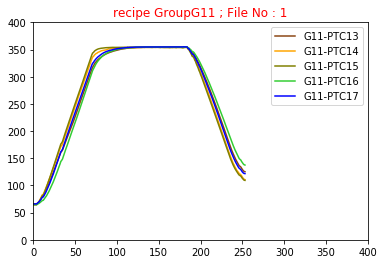

<Figure size 1600x1280 with 0 Axes>

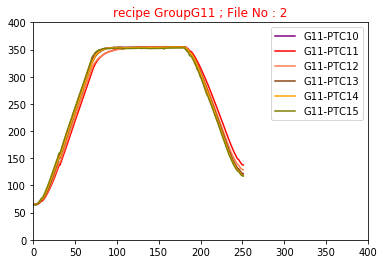

<Figure size 1600x1280 with 0 Axes>

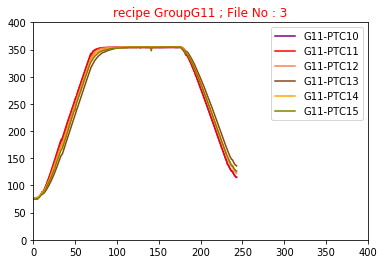

<Figure size 1600x1280 with 0 Axes>

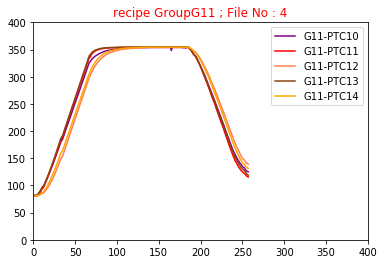

<Figure size 1600x1280 with 0 Axes>

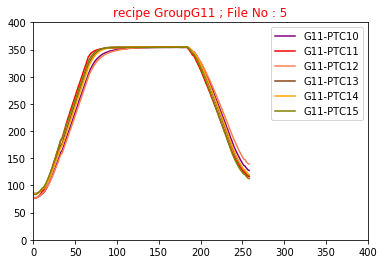

<Figure size 1600x1280 with 0 Axes>

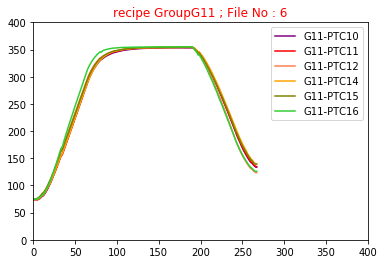

<Figure size 1600x1280 with 0 Axes>

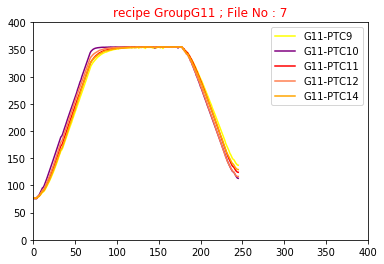

<Figure size 1600x1280 with 0 Axes>

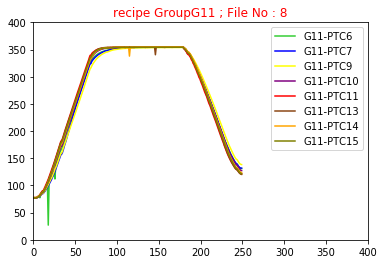

<Figure size 1600x1280 with 0 Axes>

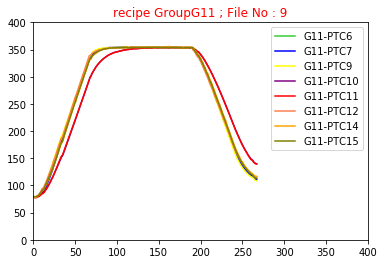

<Figure size 1600x1280 with 0 Axes>

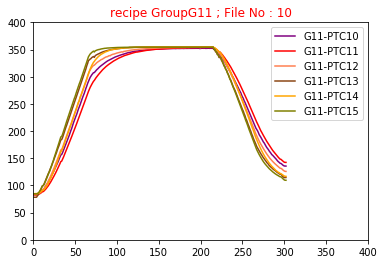

<Figure size 1600x1280 with 0 Axes>

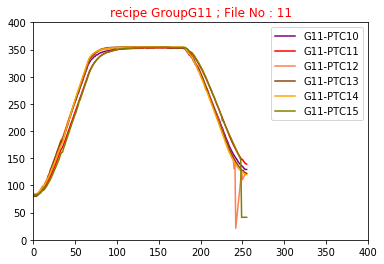

<Figure size 1600x1280 with 0 Axes>

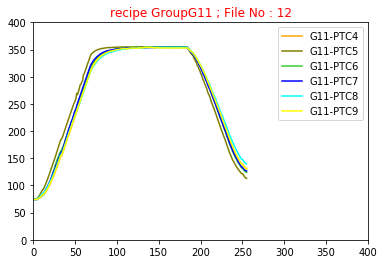

<Figure size 1600x1280 with 0 Axes>

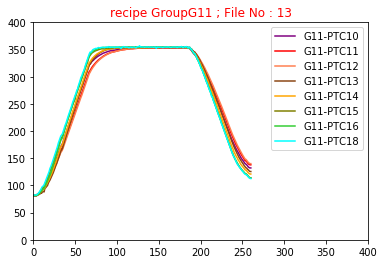

<Figure size 1600x1280 with 0 Axes>

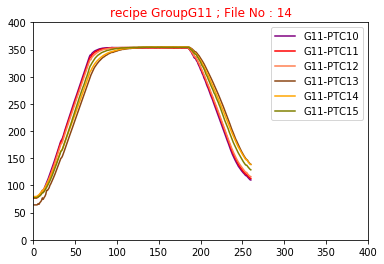

<Figure size 1600x1280 with 0 Axes>

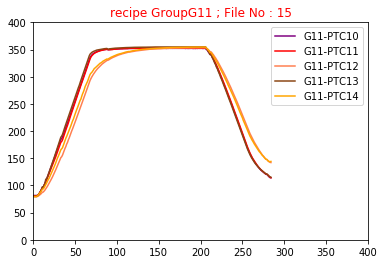

<Figure size 1600x1280 with 0 Axes>

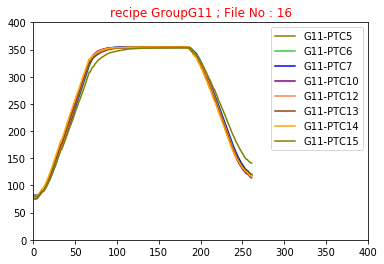

<Figure size 1600x1280 with 0 Axes>

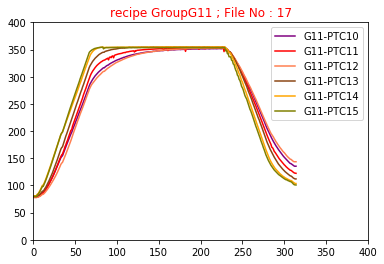

<Figure size 1600x1280 with 0 Axes>

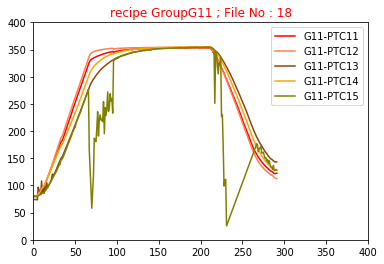

<Figure size 1600x1280 with 0 Axes>

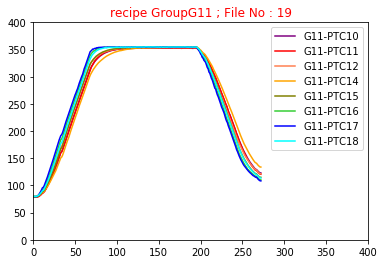

<Figure size 1600x1280 with 0 Axes>

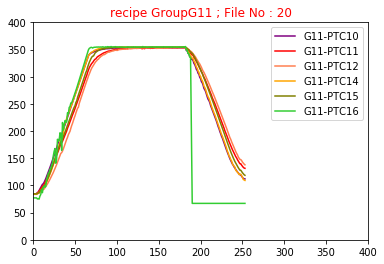

<Figure size 1600x1280 with 0 Axes>

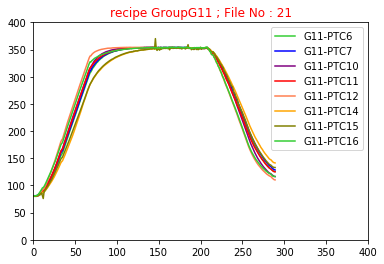

<Figure size 1600x1280 with 0 Axes>

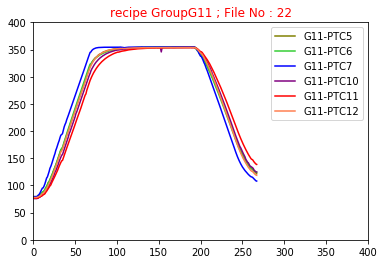

<Figure size 1600x1280 with 0 Axes>

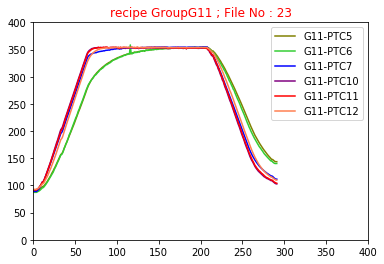

<Figure size 1600x1280 with 0 Axes>

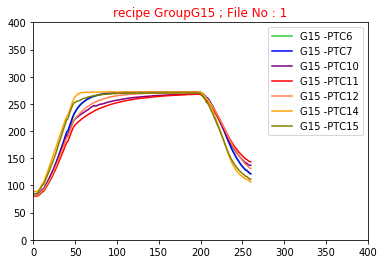

<Figure size 1600x1280 with 0 Axes>

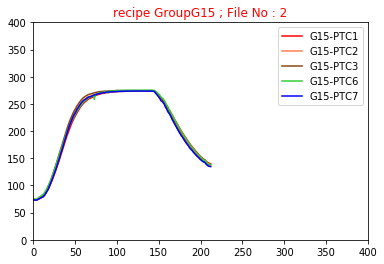

<Figure size 1600x1280 with 0 Axes>

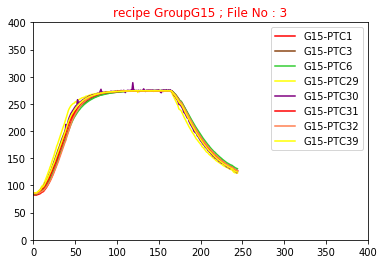

<Figure size 1600x1280 with 0 Axes>

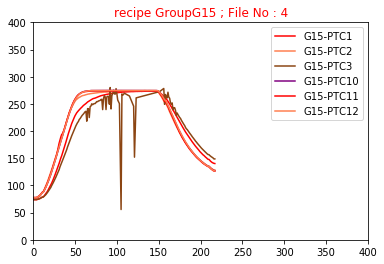

<Figure size 1600x1280 with 0 Axes>

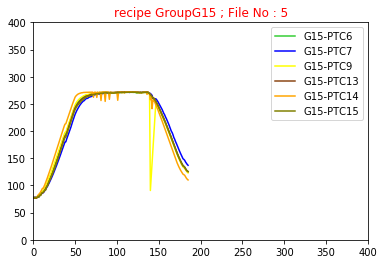

<Figure size 1600x1280 with 0 Axes>

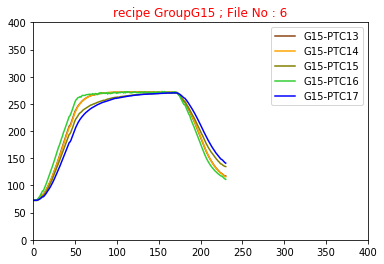

<Figure size 1600x1280 with 0 Axes>

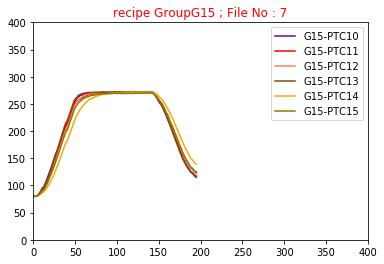

<Figure size 1600x1280 with 0 Axes>

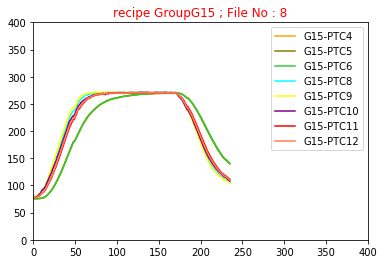

<Figure size 1600x1280 with 0 Axes>

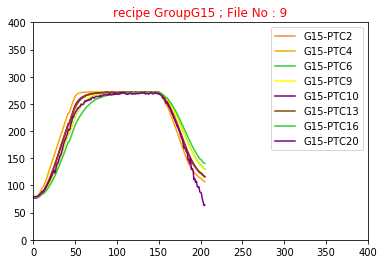

<Figure size 1600x1280 with 0 Axes>

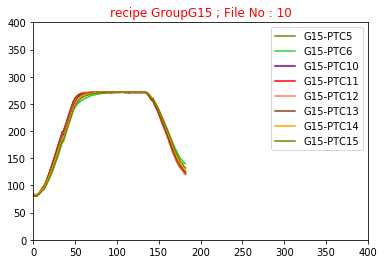

<Figure size 1600x1280 with 0 Axes>

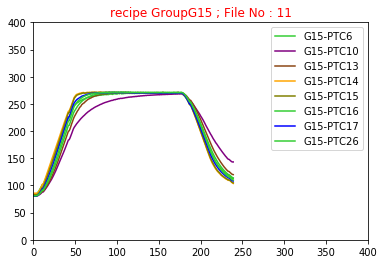

<Figure size 1600x1280 with 0 Axes>

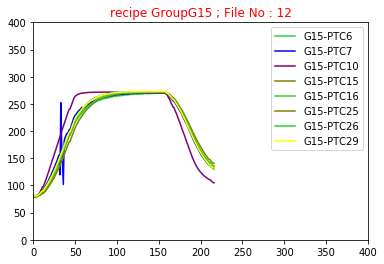

<Figure size 1600x1280 with 0 Axes>

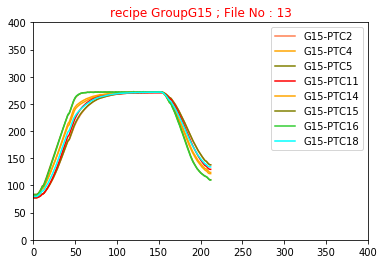

<Figure size 1600x1280 with 0 Axes>

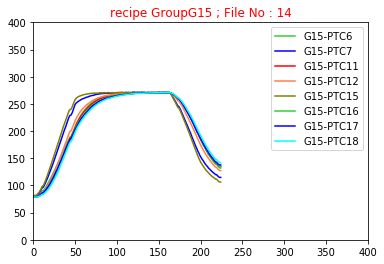

<Figure size 1600x1280 with 0 Axes>

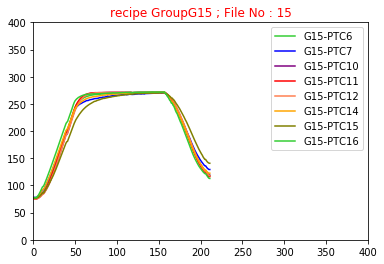

<Figure size 1600x1280 with 0 Axes>

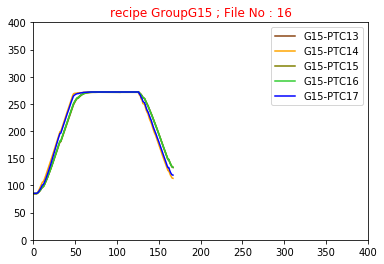

<Figure size 1600x1280 with 0 Axes>

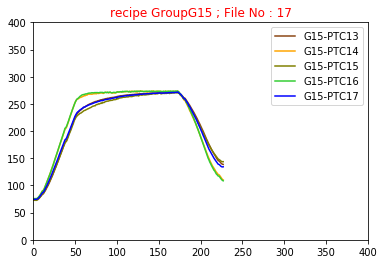

<Figure size 1600x1280 with 0 Axes>

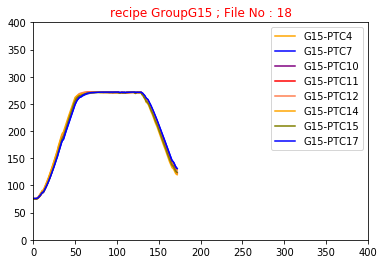

<Figure size 1600x1280 with 0 Axes>

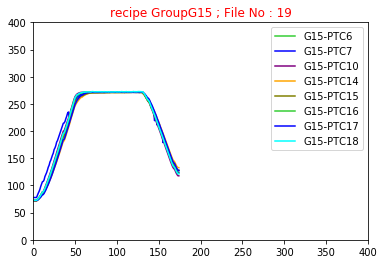

<Figure size 1600x1280 with 0 Axes>

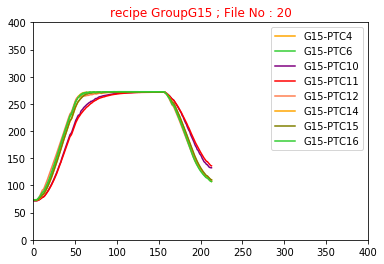

<Figure size 1600x1280 with 0 Axes>

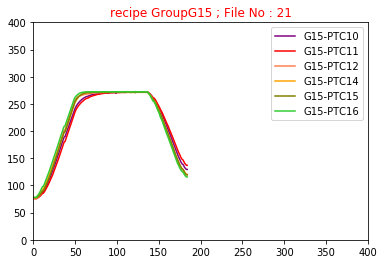

<Figure size 1600x1280 with 0 Axes>

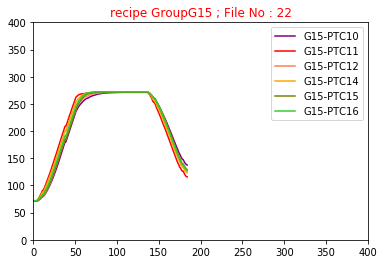

<Figure size 1600x1280 with 0 Axes>

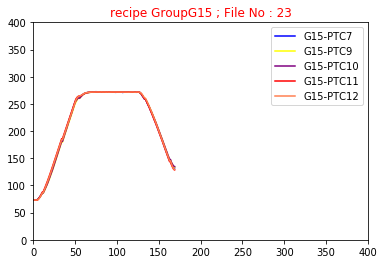

<Figure size 1600x1280 with 0 Axes>

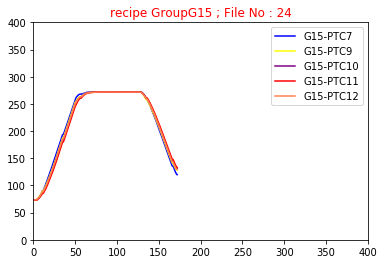

<Figure size 1600x1280 with 0 Axes>

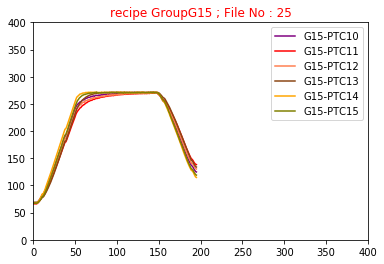

<Figure size 1600x1280 with 0 Axes>

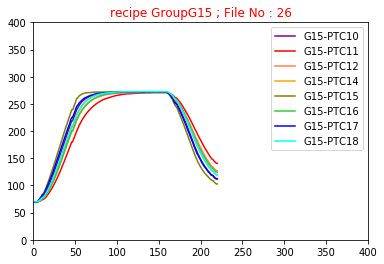

<Figure size 1600x1280 with 0 Axes>

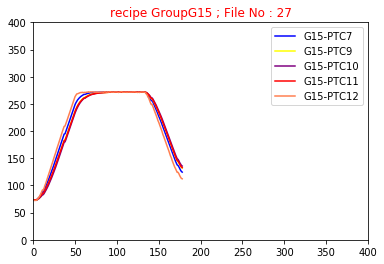

<Figure size 1600x1280 with 0 Axes>

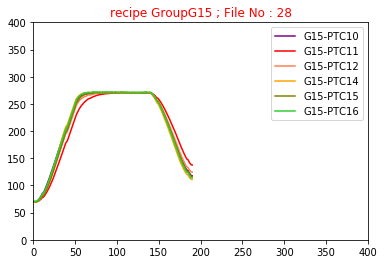

<Figure size 1600x1280 with 0 Axes>

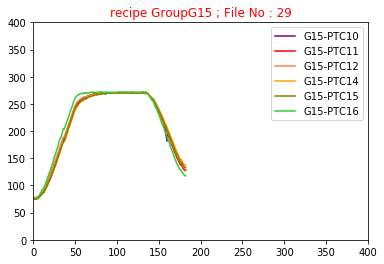

<Figure size 1600x1280 with 0 Axes>

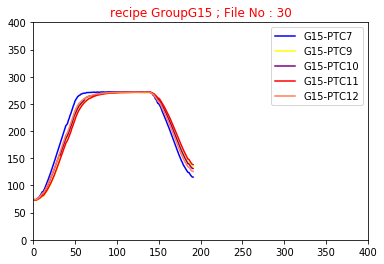

<Figure size 1600x1280 with 0 Axes>

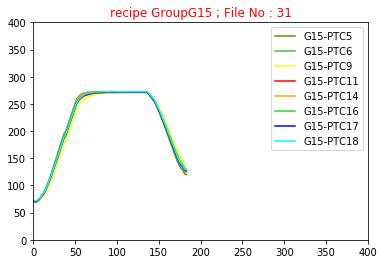

<Figure size 1600x1280 with 0 Axes>

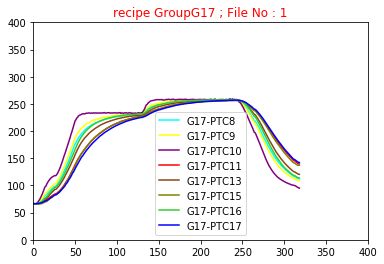

<Figure size 1600x1280 with 0 Axes>

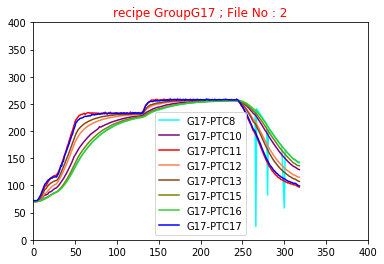

<Figure size 1600x1280 with 0 Axes>

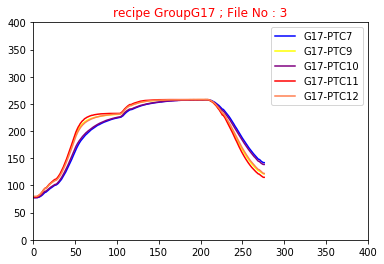

<Figure size 1600x1280 with 0 Axes>

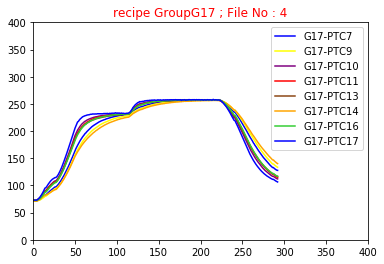

<Figure size 1600x1280 with 0 Axes>

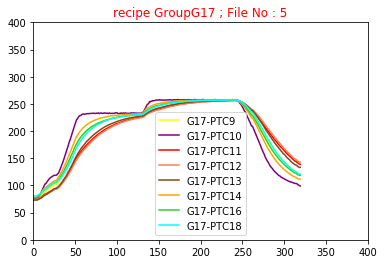

<Figure size 1600x1280 with 0 Axes>

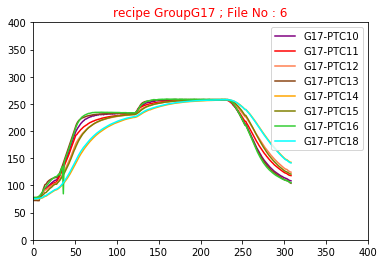

<Figure size 1600x1280 with 0 Axes>

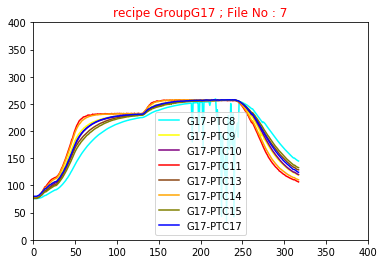

<Figure size 1600x1280 with 0 Axes>

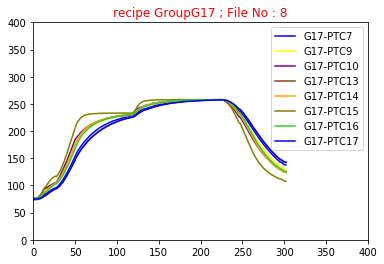

<Figure size 1600x1280 with 0 Axes>

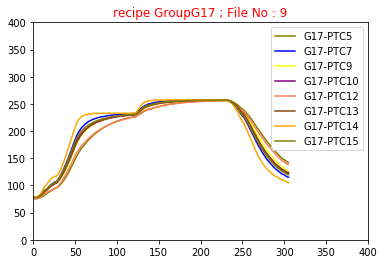

<Figure size 1600x1280 with 0 Axes>

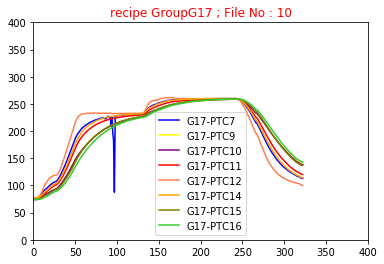

<Figure size 1600x1280 with 0 Axes>

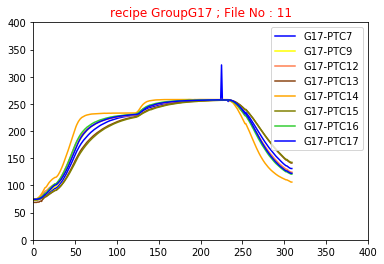

<Figure size 1600x1280 with 0 Axes>

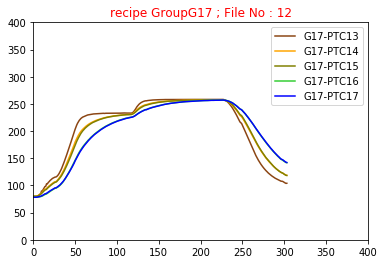

<Figure size 1600x1280 with 0 Axes>

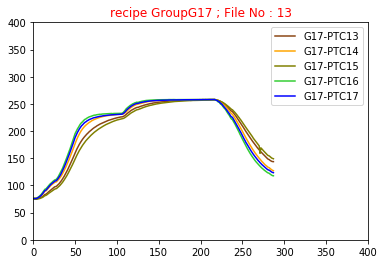

<Figure size 1600x1280 with 0 Axes>

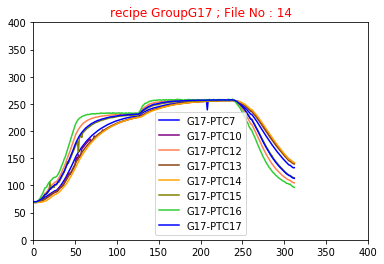

<Figure size 1600x1280 with 0 Axes>

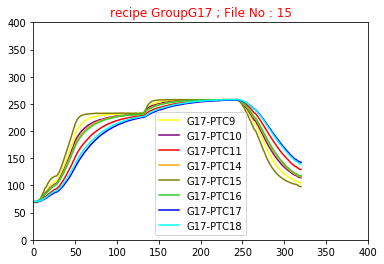

<Figure size 1600x1280 with 0 Axes>

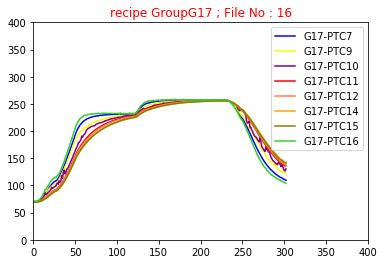

<Figure size 1600x1280 with 0 Axes>

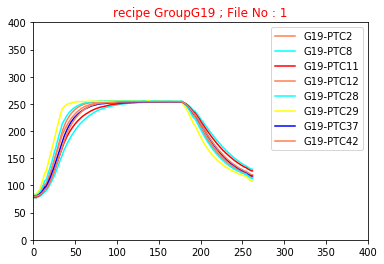

<Figure size 1600x1280 with 0 Axes>

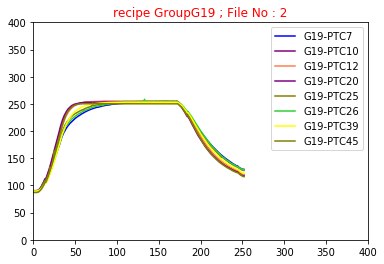

<Figure size 1600x1280 with 0 Axes>

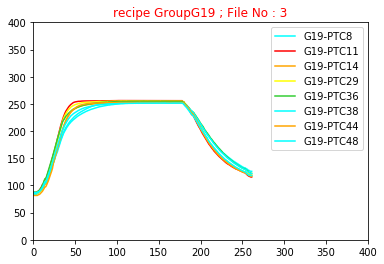

<Figure size 1600x1280 with 0 Axes>

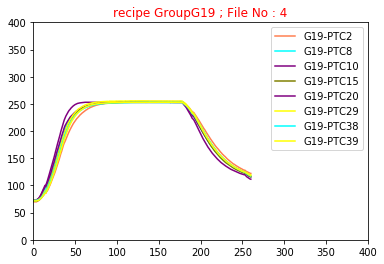

<Figure size 1600x1280 with 0 Axes>

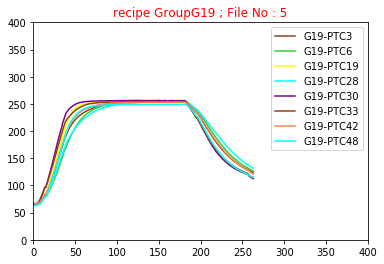

<Figure size 1600x1280 with 0 Axes>

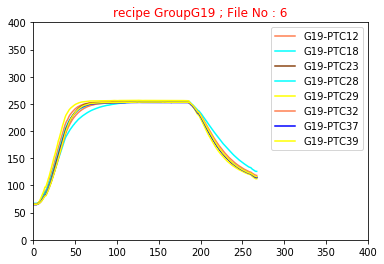

<Figure size 1600x1280 with 0 Axes>

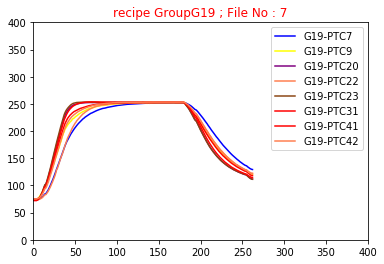

<Figure size 1600x1280 with 0 Axes>

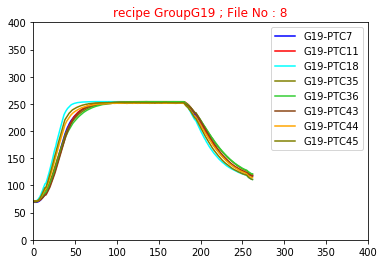

<Figure size 1600x1280 with 0 Axes>

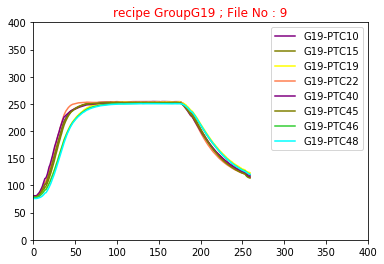

<Figure size 1600x1280 with 0 Axes>

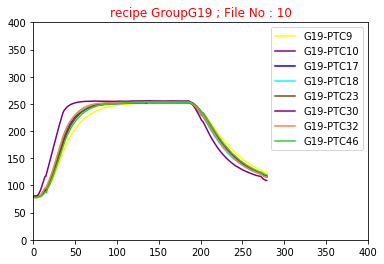

<Figure size 1600x1280 with 0 Axes>

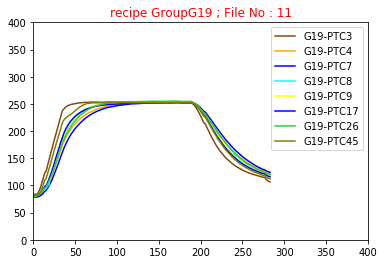

<Figure size 1600x1280 with 0 Axes>

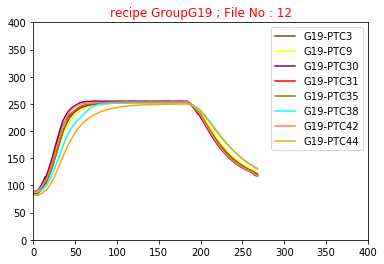

<Figure size 1600x1280 with 0 Axes>

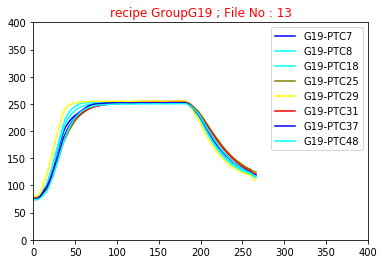

<Figure size 1600x1280 with 0 Axes>

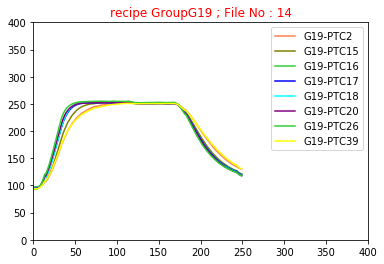

<Figure size 1600x1280 with 0 Axes>

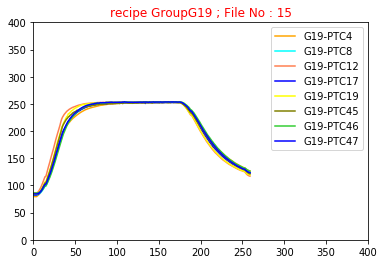

<Figure size 1600x1280 with 0 Axes>

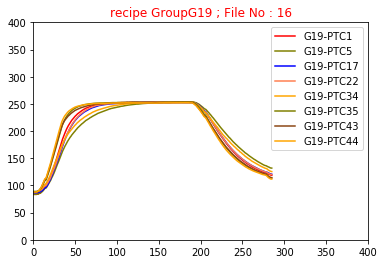

<Figure size 1600x1280 with 0 Axes>

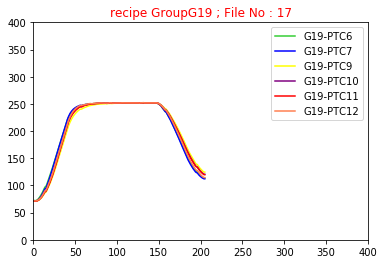

<Figure size 1600x1280 with 0 Axes>

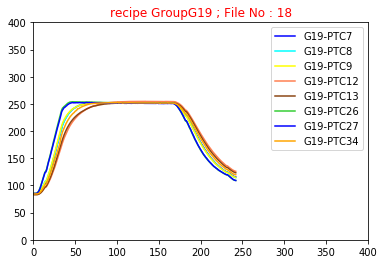

<Figure size 1600x1280 with 0 Axes>

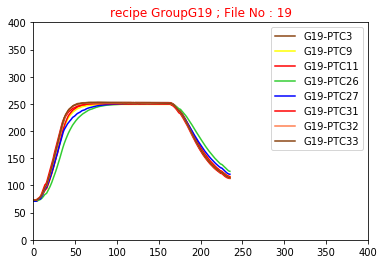

<Figure size 1600x1280 with 0 Axes>

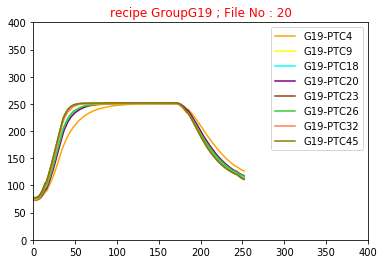

<Figure size 1600x1280 with 0 Axes>

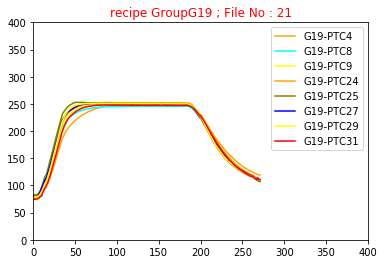

<Figure size 1600x1280 with 0 Axes>

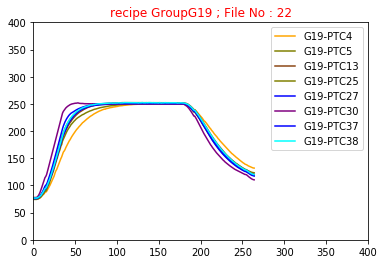

<Figure size 1600x1280 with 0 Axes>

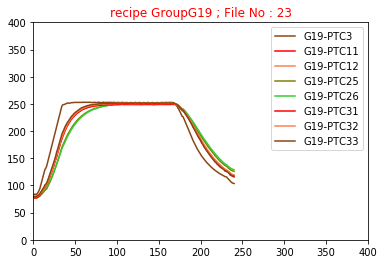

<Figure size 1600x1280 with 0 Axes>

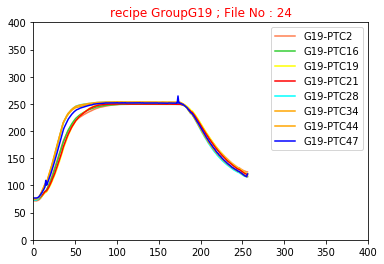

<Figure size 1600x1280 with 0 Axes>

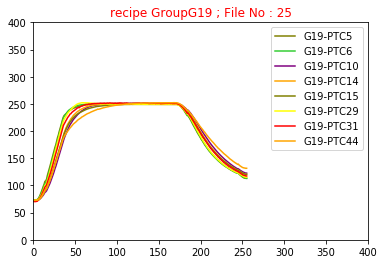

<Figure size 1600x1280 with 0 Axes>

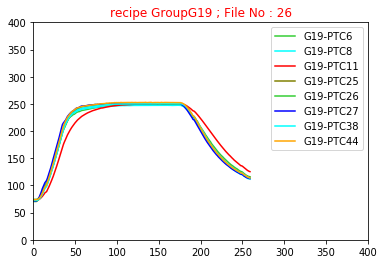

<Figure size 1600x1280 with 0 Axes>

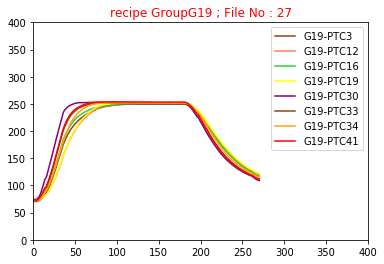

<Figure size 1600x1280 with 0 Axes>

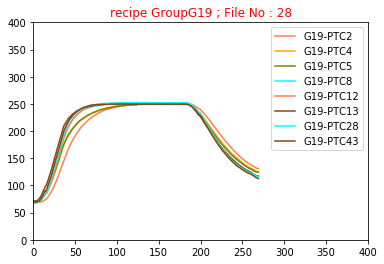

<Figure size 1600x1280 with 0 Axes>

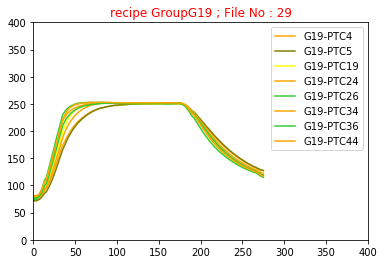

<Figure size 1600x1280 with 0 Axes>

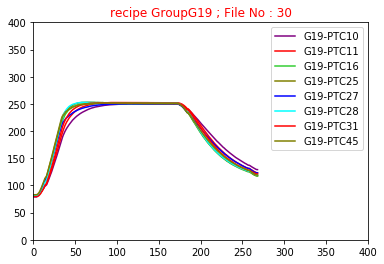

<Figure size 1600x1280 with 0 Axes>

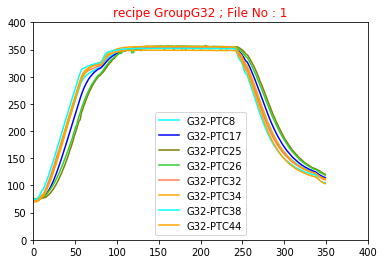

<Figure size 1600x1280 with 0 Axes>

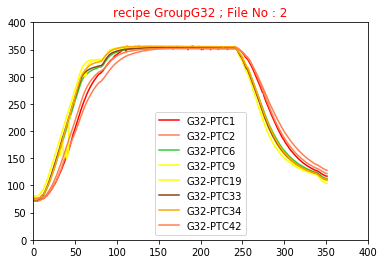

<Figure size 1600x1280 with 0 Axes>

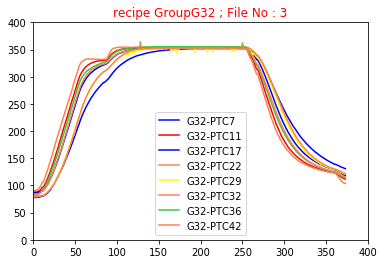

<Figure size 1600x1280 with 0 Axes>

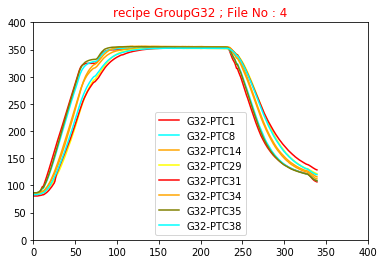

<Figure size 1600x1280 with 0 Axes>

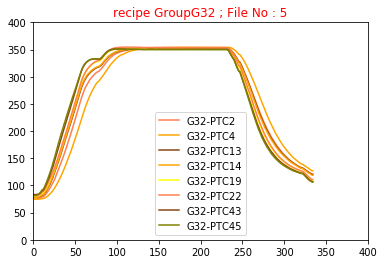

<Figure size 1600x1280 with 0 Axes>

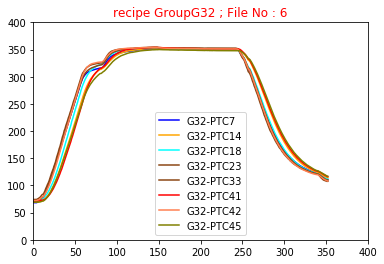

<Figure size 1600x1280 with 0 Axes>

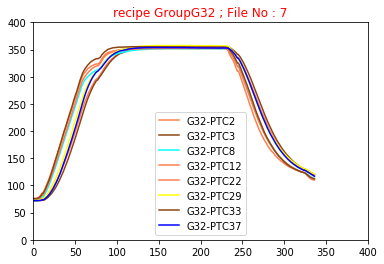

<Figure size 1600x1280 with 0 Axes>

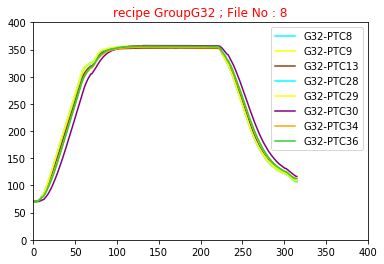

<Figure size 1600x1280 with 0 Axes>

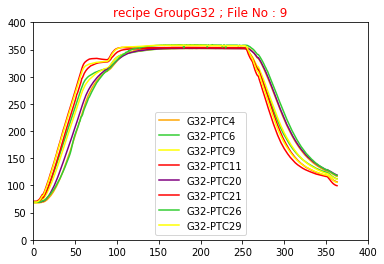

<Figure size 1600x1280 with 0 Axes>

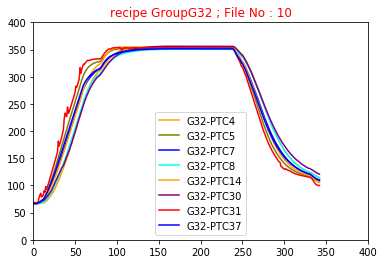

<Figure size 1600x1280 with 0 Axes>

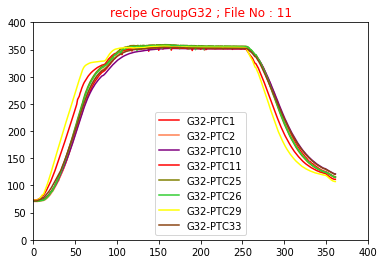

<Figure size 1600x1280 with 0 Axes>

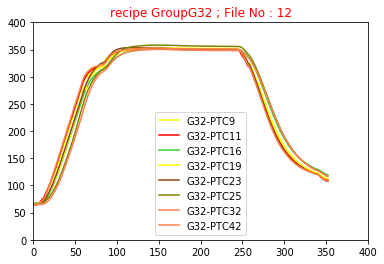

<Figure size 1600x1280 with 0 Axes>

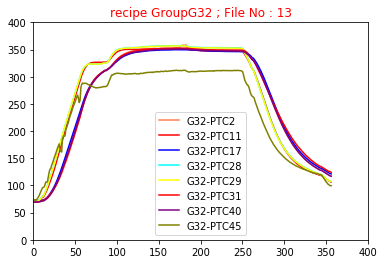

<Figure size 1600x1280 with 0 Axes>

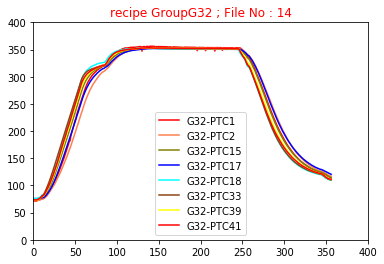

<Figure size 1600x1280 with 0 Axes>

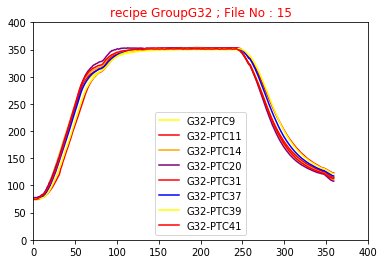

<Figure size 1600x1280 with 0 Axes>

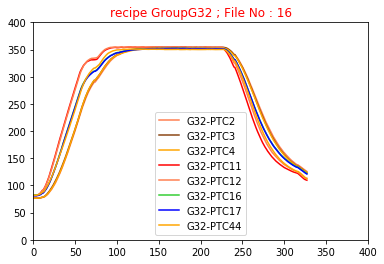

<Figure size 1600x1280 with 0 Axes>

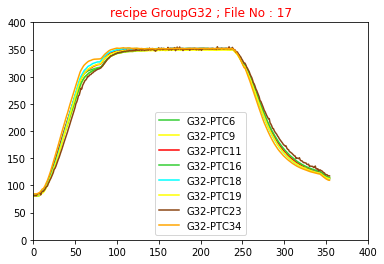

<Figure size 1600x1280 with 0 Axes>

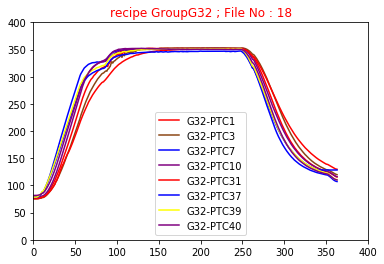

<Figure size 1600x1280 with 0 Axes>

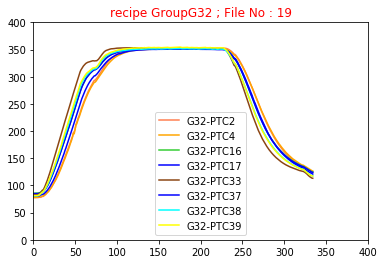

<Figure size 1600x1280 with 0 Axes>

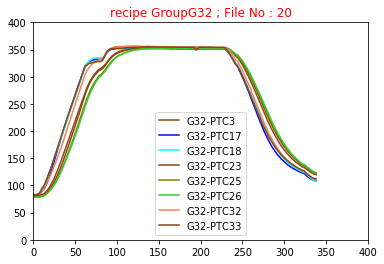

<Figure size 1600x1280 with 0 Axes>

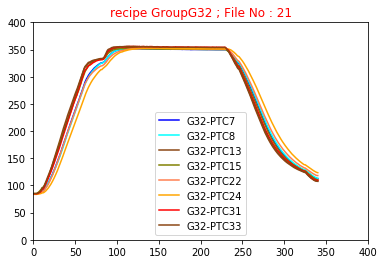

<Figure size 1600x1280 with 0 Axes>

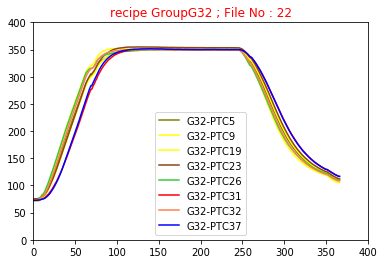

<Figure size 1600x1280 with 0 Axes>

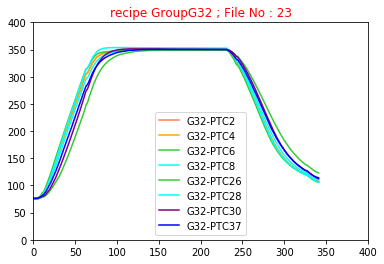

<Figure size 1600x1280 with 0 Axes>

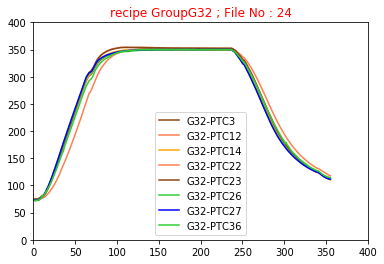

<Figure size 1600x1280 with 0 Axes>

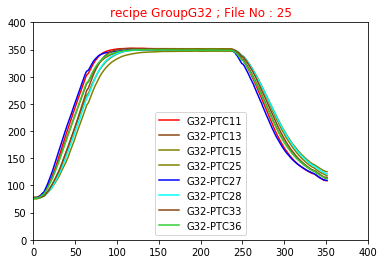

<Figure size 1600x1280 with 0 Axes>

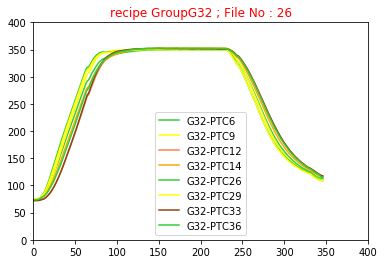

<Figure size 1600x1280 with 0 Axes>

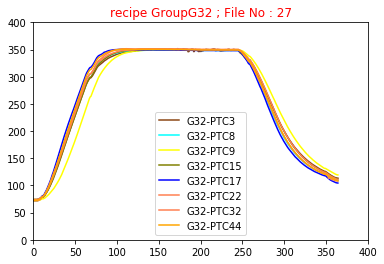

<Figure size 1600x1280 with 0 Axes>

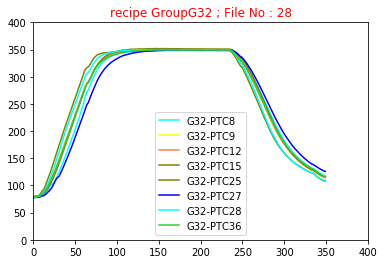

<Figure size 1600x1280 with 0 Axes>

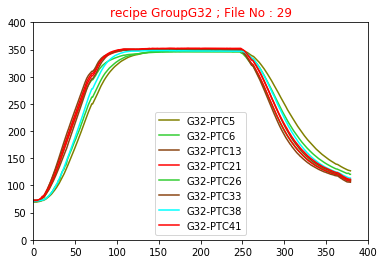

<Figure size 1600x1280 with 0 Axes>

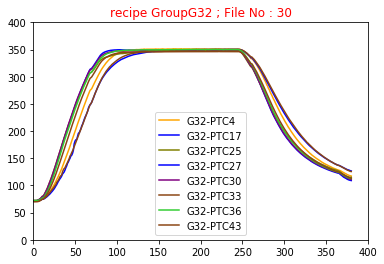

<Figure size 1600x1280 with 0 Axes>

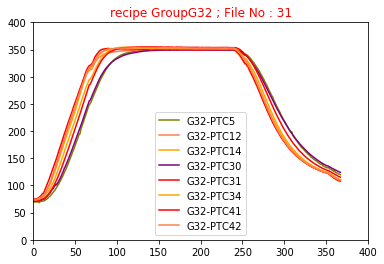

<Figure size 1600x1280 with 0 Axes>

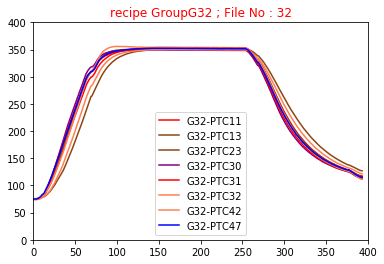

<Figure size 1600x1280 with 0 Axes>

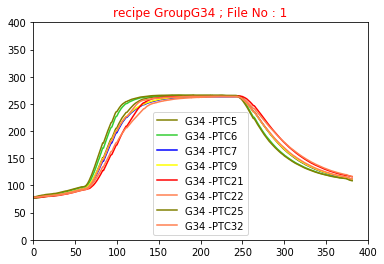

<Figure size 1600x1280 with 0 Axes>

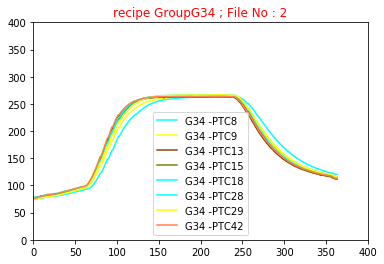

<Figure size 1600x1280 with 0 Axes>

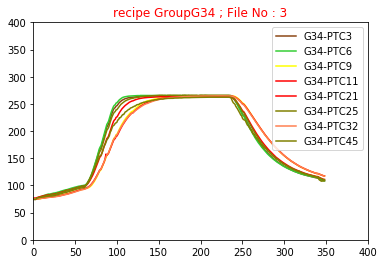

<Figure size 1600x1280 with 0 Axes>

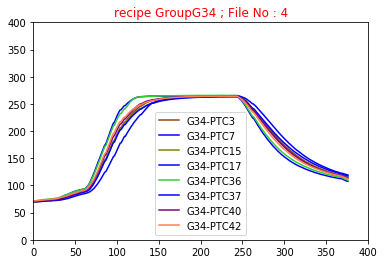

<Figure size 1600x1280 with 0 Axes>

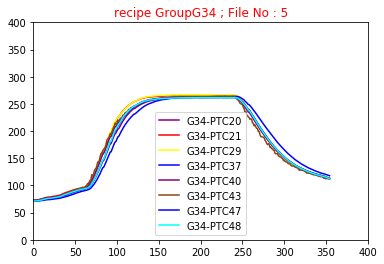

<Figure size 1600x1280 with 0 Axes>

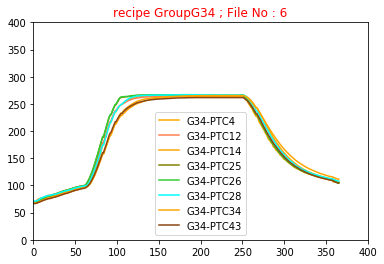

<Figure size 1600x1280 with 0 Axes>

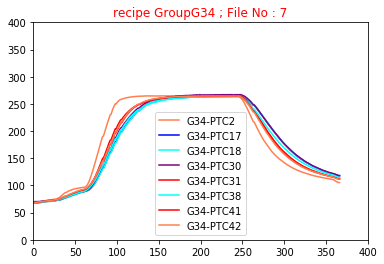

<Figure size 1600x1280 with 0 Axes>

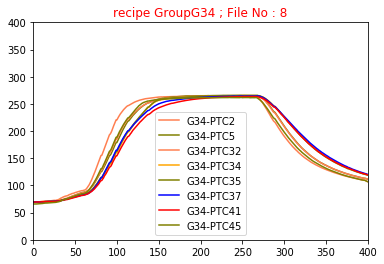

<Figure size 1600x1280 with 0 Axes>

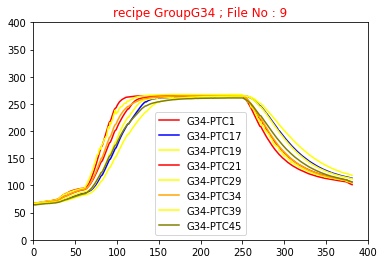

<Figure size 1600x1280 with 0 Axes>

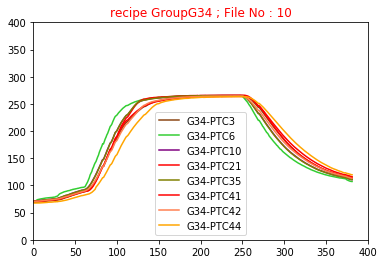

<Figure size 1600x1280 with 0 Axes>

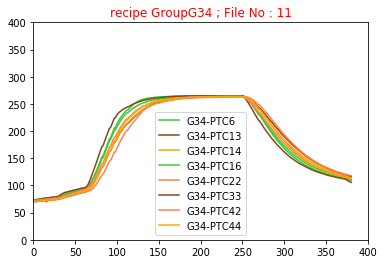

<Figure size 1600x1280 with 0 Axes>

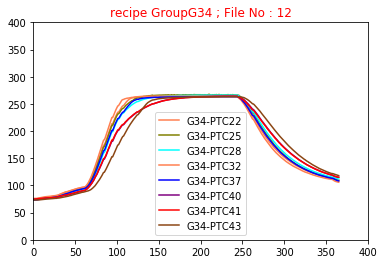

<Figure size 1600x1280 with 0 Axes>

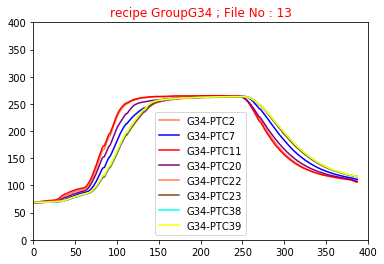

<Figure size 1600x1280 with 0 Axes>

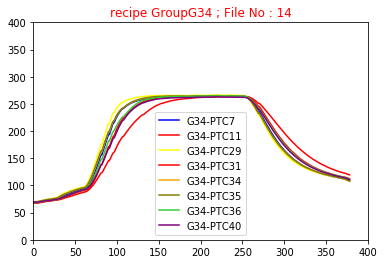

<Figure size 1600x1280 with 0 Axes>

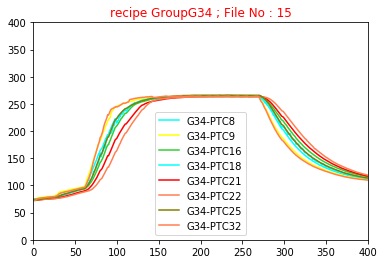

<Figure size 1600x1280 with 0 Axes>

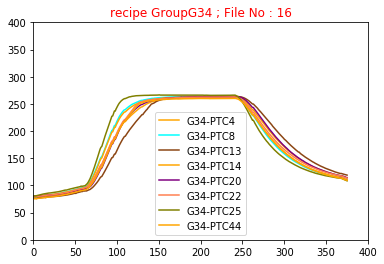

<Figure size 1600x1280 with 0 Axes>

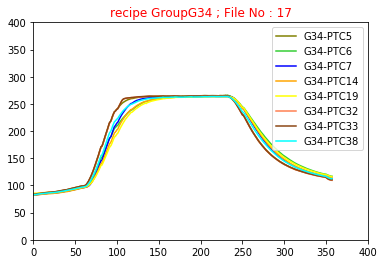

<Figure size 1600x1280 with 0 Axes>

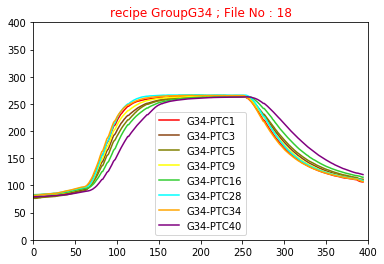

<Figure size 1600x1280 with 0 Axes>

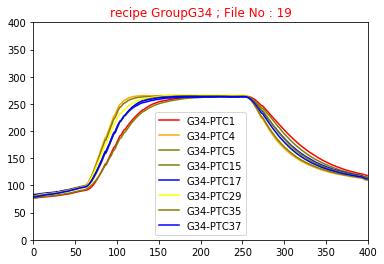

<Figure size 1600x1280 with 0 Axes>

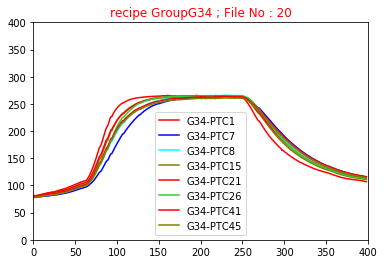

<Figure size 1600x1280 with 0 Axes>

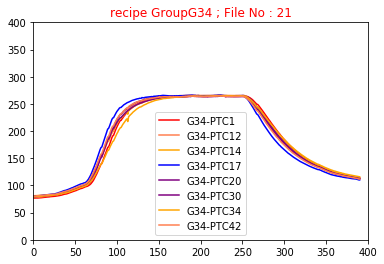

<Figure size 1600x1280 with 0 Axes>

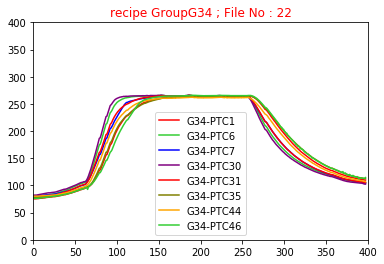

<Figure size 1600x1280 with 0 Axes>

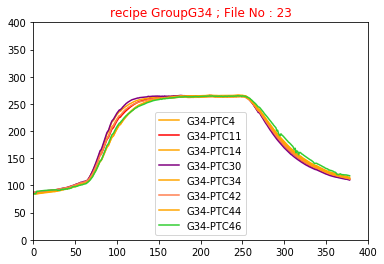

<Figure size 1600x1280 with 0 Axes>

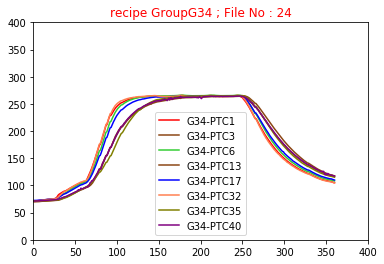

<Figure size 1600x1280 with 0 Axes>

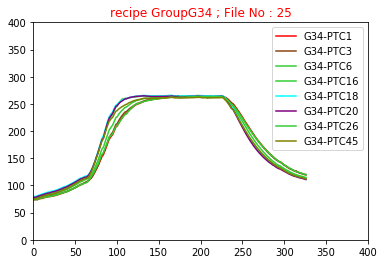

<Figure size 1600x1280 with 0 Axes>

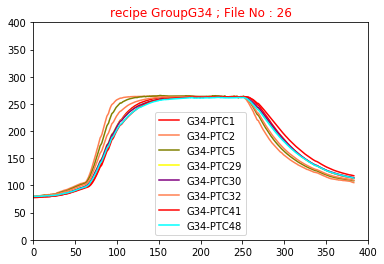

<Figure size 1600x1280 with 0 Axes>

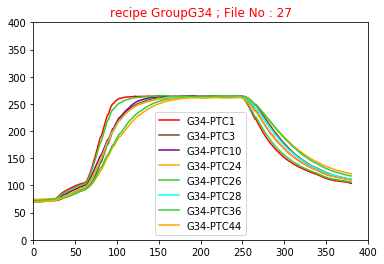

<Figure size 1600x1280 with 0 Axes>

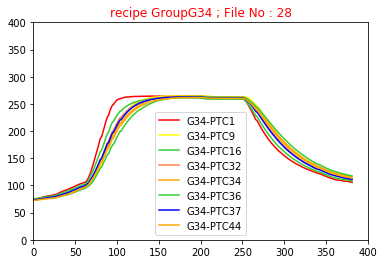

<Figure size 1600x1280 with 0 Axes>

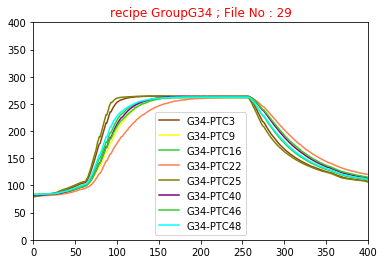

<Figure size 1600x1280 with 0 Axes>

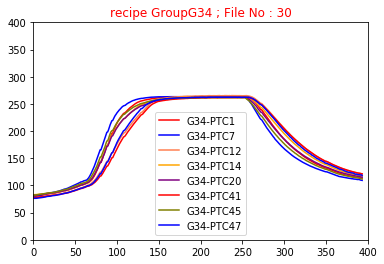

<Figure size 1600x1280 with 0 Axes>

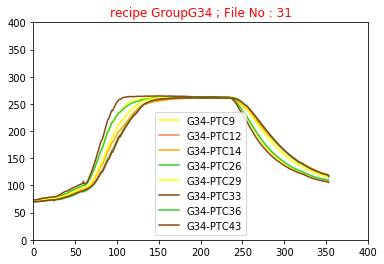

<Figure size 1600x1280 with 0 Axes>

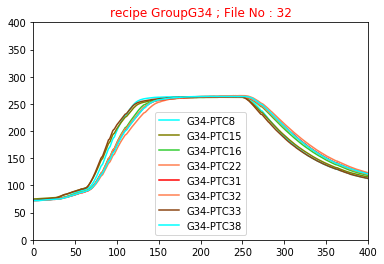

<Figure size 1600x1280 with 0 Axes>

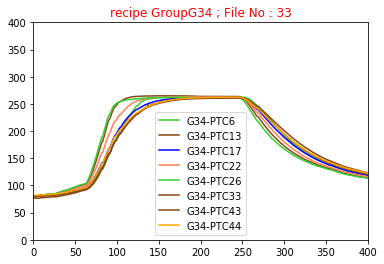

<Figure size 1600x1280 with 0 Axes>

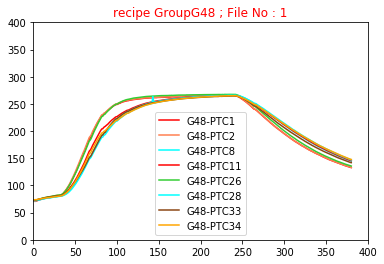

<Figure size 1600x1280 with 0 Axes>

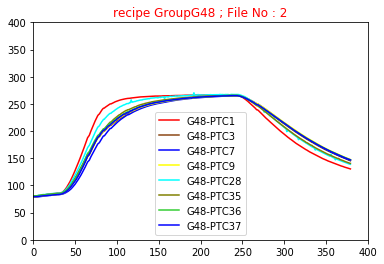

<Figure size 1600x1280 with 0 Axes>

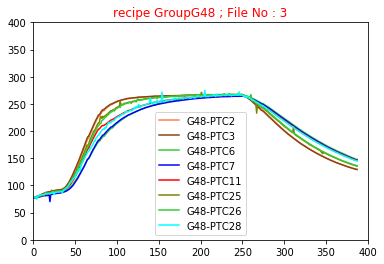

<Figure size 1600x1280 with 0 Axes>

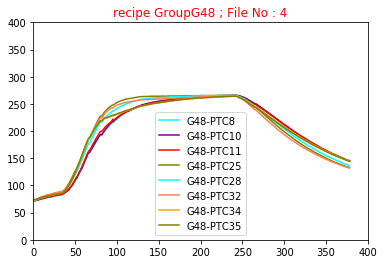

<Figure size 1600x1280 with 0 Axes>

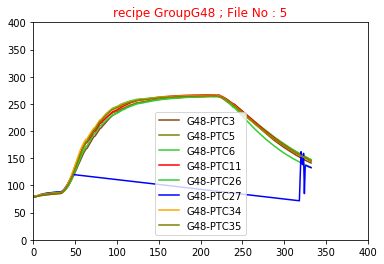

<Figure size 1600x1280 with 0 Axes>

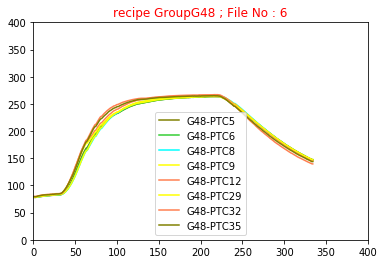

<Figure size 1600x1280 with 0 Axes>

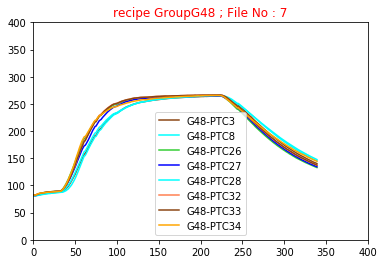

<Figure size 1600x1280 with 0 Axes>

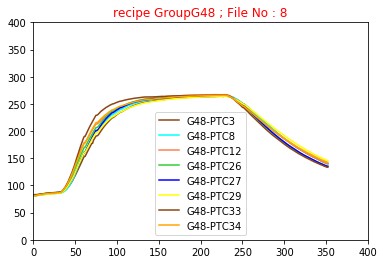

<Figure size 1600x1280 with 0 Axes>

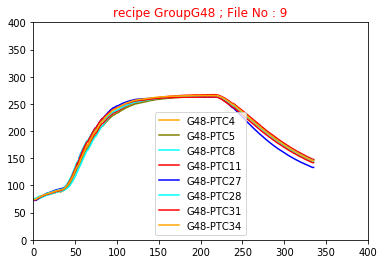

<Figure size 1600x1280 with 0 Axes>

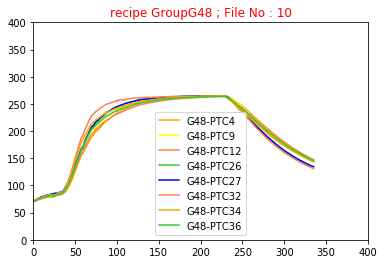

<Figure size 1600x1280 with 0 Axes>

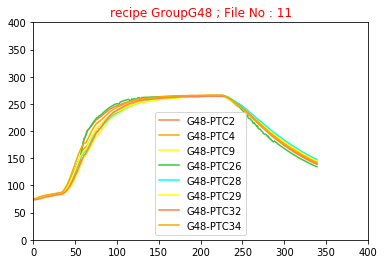

<Figure size 1600x1280 with 0 Axes>

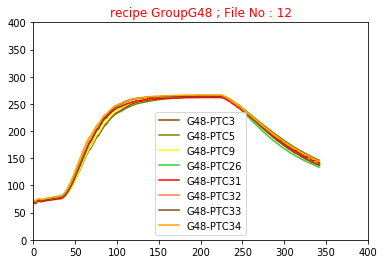

<Figure size 1600x1280 with 0 Axes>

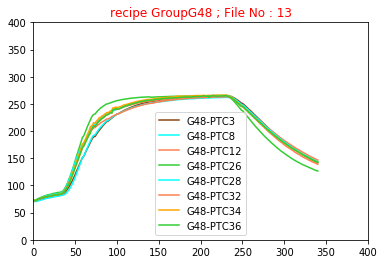

<Figure size 1600x1280 with 0 Axes>

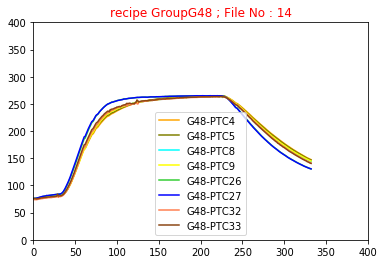

<Figure size 1600x1280 with 0 Axes>

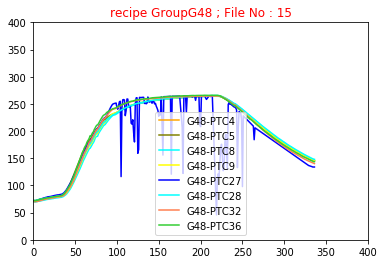

<Figure size 1600x1280 with 0 Axes>

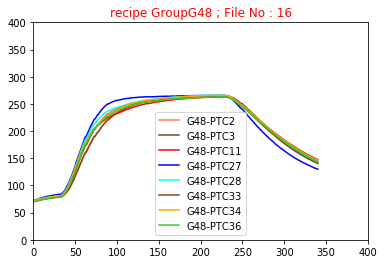

<Figure size 1600x1280 with 0 Axes>

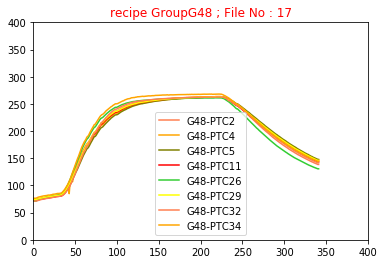

<Figure size 1600x1280 with 0 Axes>

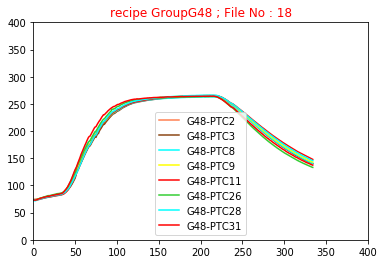

<Figure size 1600x1280 with 0 Axes>

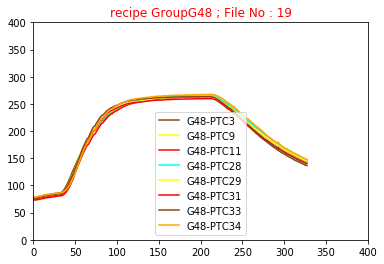

<Figure size 1600x1280 with 0 Axes>

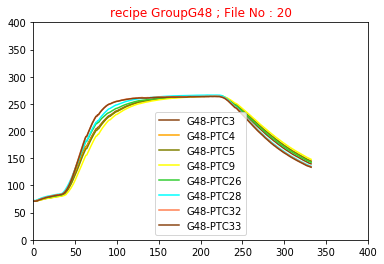

<Figure size 1600x1280 with 0 Axes>

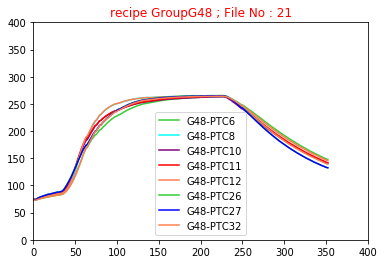

<Figure size 1600x1280 with 0 Axes>

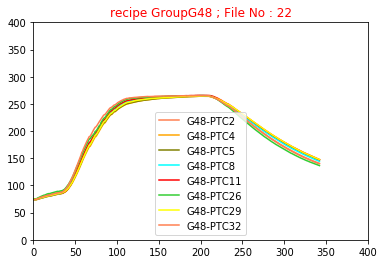

<Figure size 1600x1280 with 0 Axes>

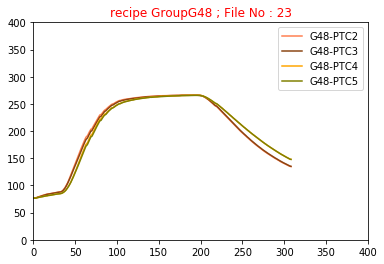

<Figure size 1600x1280 with 0 Axes>

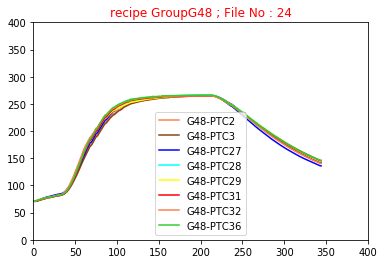

<Figure size 1600x1280 with 0 Axes>

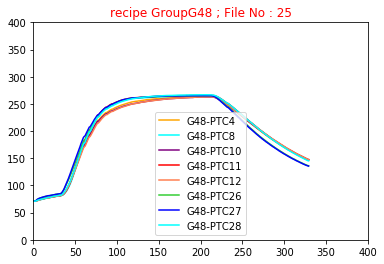

<Figure size 1600x1280 with 0 Axes>

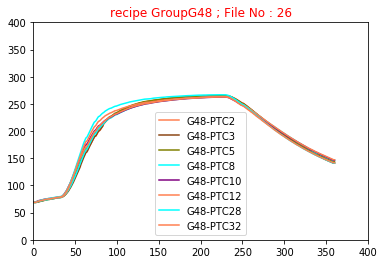

<Figure size 1600x1280 with 0 Axes>

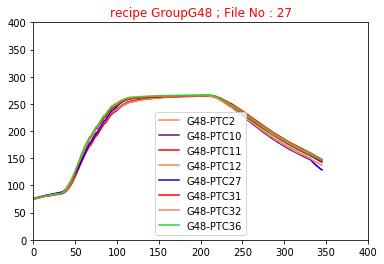

<Figure size 1600x1280 with 0 Axes>

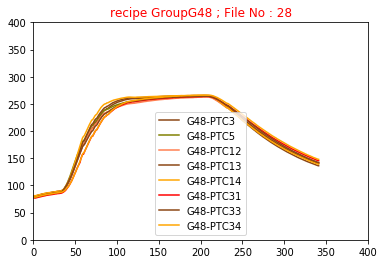

<Figure size 1600x1280 with 0 Axes>

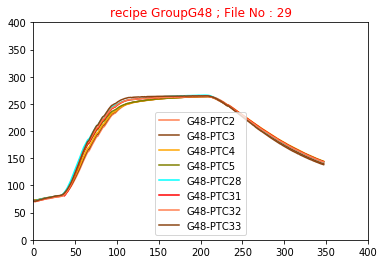

<Figure size 1600x1280 with 0 Axes>

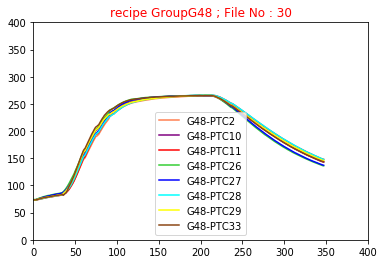

<Figure size 1600x1280 with 0 Axes>

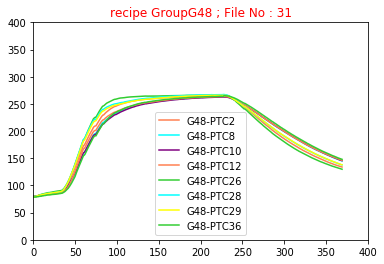

<Figure size 1600x1280 with 0 Axes>

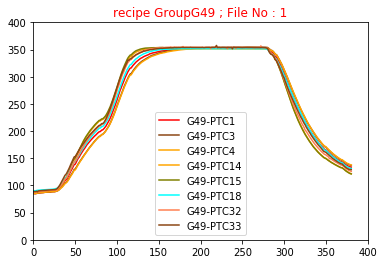

<Figure size 1600x1280 with 0 Axes>

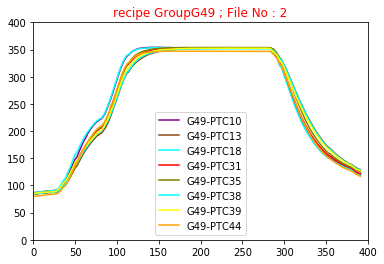

<Figure size 1600x1280 with 0 Axes>

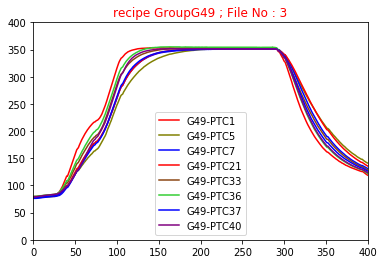

<Figure size 1600x1280 with 0 Axes>

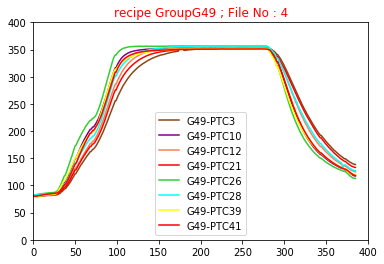

<Figure size 1600x1280 with 0 Axes>

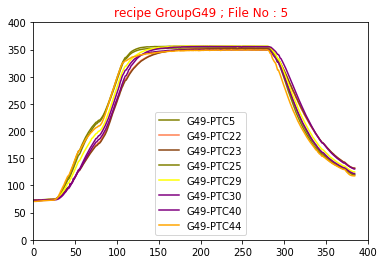

<Figure size 1600x1280 with 0 Axes>

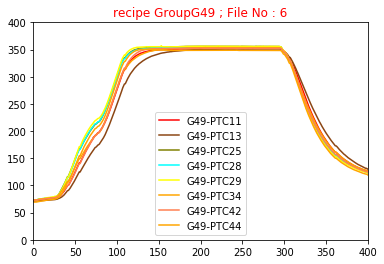

<Figure size 1600x1280 with 0 Axes>

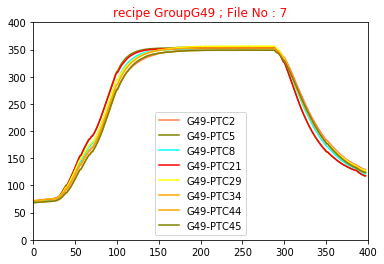

<Figure size 1600x1280 with 0 Axes>

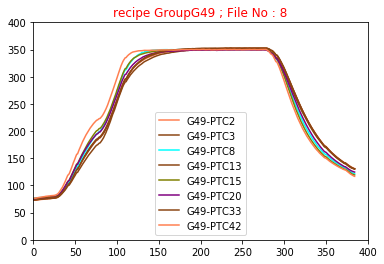

<Figure size 1600x1280 with 0 Axes>

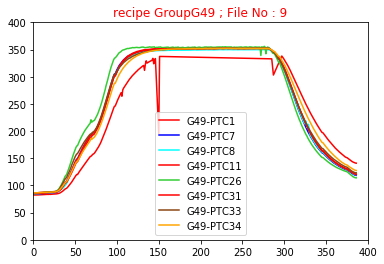

<Figure size 1600x1280 with 0 Axes>

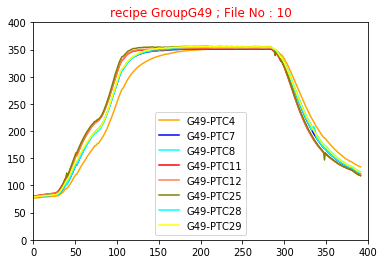

<Figure size 1600x1280 with 0 Axes>

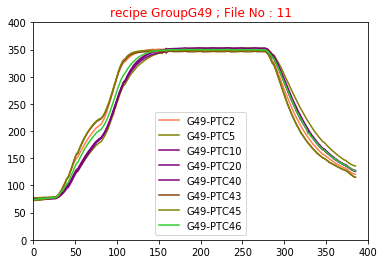

<Figure size 1600x1280 with 0 Axes>

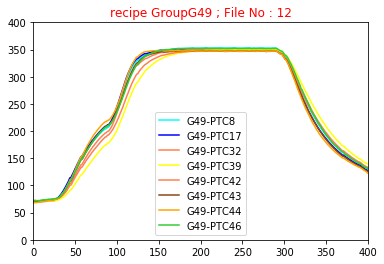

<Figure size 1600x1280 with 0 Axes>

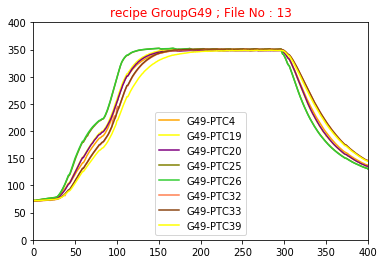

<Figure size 1600x1280 with 0 Axes>

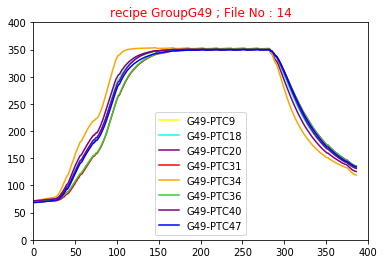

<Figure size 1600x1280 with 0 Axes>

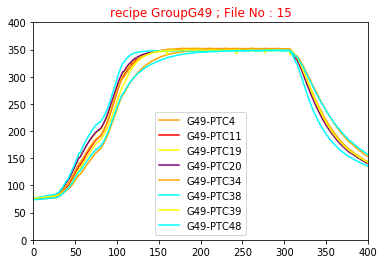

<Figure size 1600x1280 with 0 Axes>

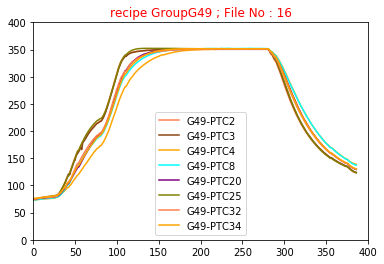

<Figure size 1600x1280 with 0 Axes>

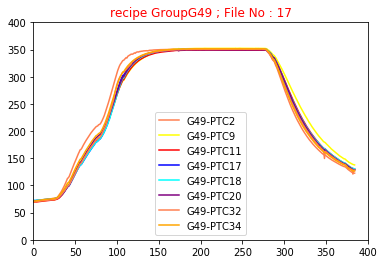

<Figure size 1600x1280 with 0 Axes>

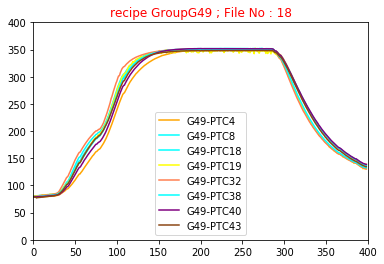

<Figure size 1600x1280 with 0 Axes>

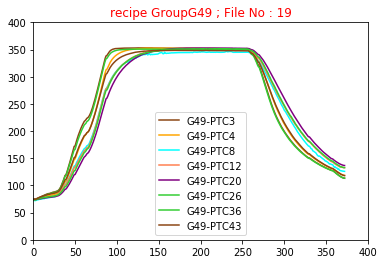

<Figure size 1600x1280 with 0 Axes>

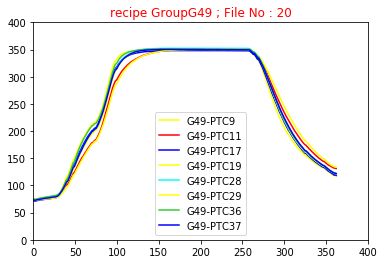

<Figure size 1600x1280 with 0 Axes>

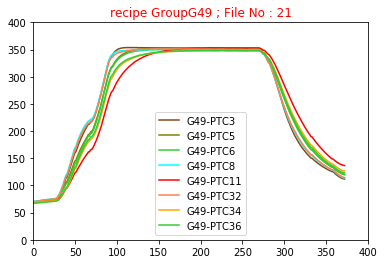

<Figure size 1600x1280 with 0 Axes>

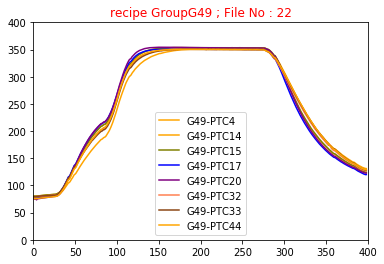

<Figure size 1600x1280 with 0 Axes>

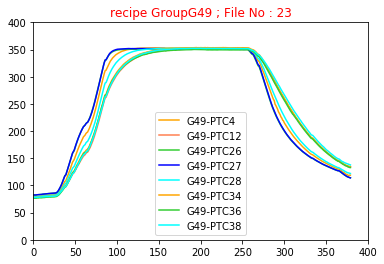

<Figure size 1600x1280 with 0 Axes>

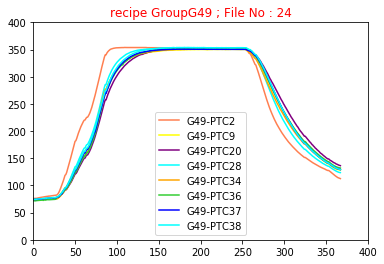

<Figure size 1600x1280 with 0 Axes>

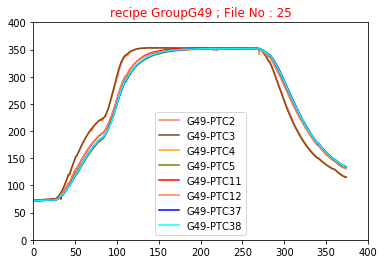

<Figure size 1600x1280 with 0 Axes>

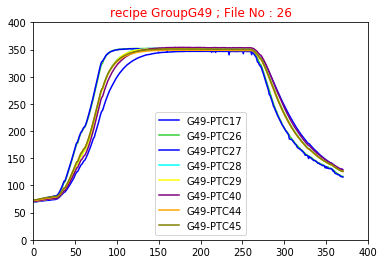

<Figure size 1600x1280 with 0 Axes>

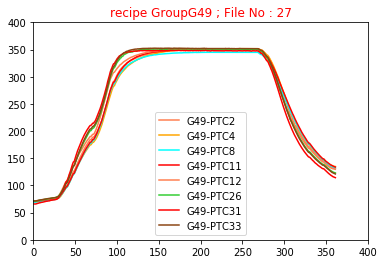

<Figure size 1600x1280 with 0 Axes>

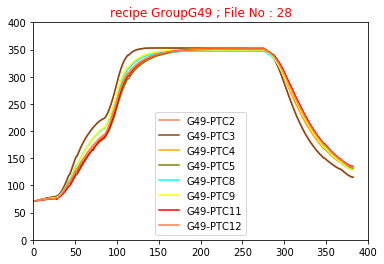

<Figure size 1600x1280 with 0 Axes>

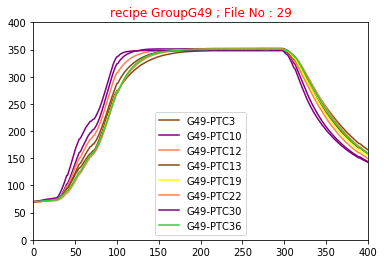

<Figure size 1600x1280 with 0 Axes>

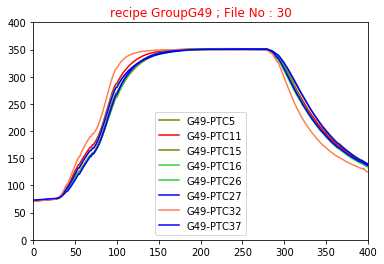

<Figure size 1600x1280 with 0 Axes>

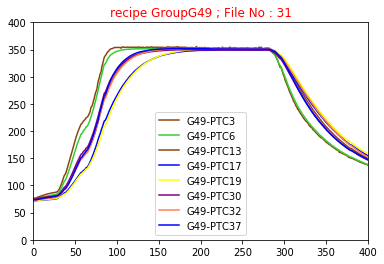

<Figure size 1600x1280 with 0 Axes>

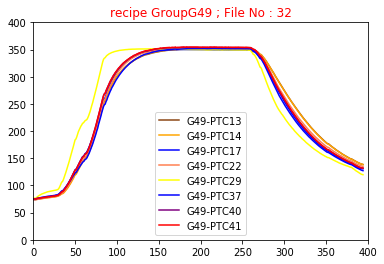

<Figure size 1600x1280 with 0 Axes>

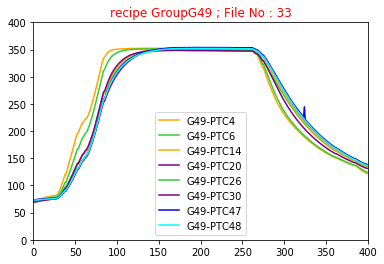

<Figure size 1600x1280 with 0 Axes>

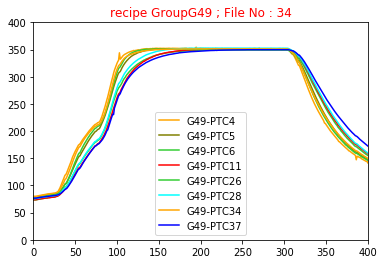

In [7]:
_plotFileCurve = True
if _plotFileCurve == True:
    for i in range(len(recipeGroup)):
        aRecipeGroupFileList = getRecipeGroupFileList(recipeGroup[i])

        for j in range(len(aRecipeGroupFileList)):

            df = readRecipeGroupFile(aRecipeGroupFileList[j])
            plotRecipeGroupFileCurve(df, recipeGroup[i],str(j+1))

# Classification Model Build

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn import svm,tree
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
import lightgbm

In [9]:
# df=df.values (dataframe to array)
rgdf_data = rgdf.drop(dropColumns, axis = 1)   #v1.08
rgdf_target = rgdf['groupid'].values
classifiers = []

In [10]:
rgdf_data.head(3)

count        mean        std   min     Q1     Q2     Q3    max  median  \
0   253  271.104743  94.558720  65.9  191.3  320.8  353.4  354.6   320.8   
1   253  271.828458  96.116089  65.8  190.8  325.9  353.8  354.2   325.9   
2   253  272.294071  96.935732  64.2  190.4  328.0  353.9  354.4   328.0   

   startT   endT  
0    65.9  125.3  
1    65.8  110.7  
2    64.2  109.3

In [11]:
drop_G = lambda x :int(x[1:])
func = np.vectorize(drop_G)
rgdf_target = func(rgdf_target) #去掉G11前的G ，並轉呈int

In [12]:
train_x , test_x , train_y , test_y = train_test_split(rgdf_data,rgdf_target
                                                       ,test_size=0.2,random_state = 123)

In [13]:
train_x = train_x.apply(pd.to_numeric, errors='coerce')                       # str to numeric
train_y = train_y.astype(np.int)  # numpy array str to int

test_x = test_x.apply(pd.to_numeric, errors='coerce')                       # str to numeric
test_y = test_y.astype(np.int)  # numpy array str to int

In [14]:
import seaborn as sns

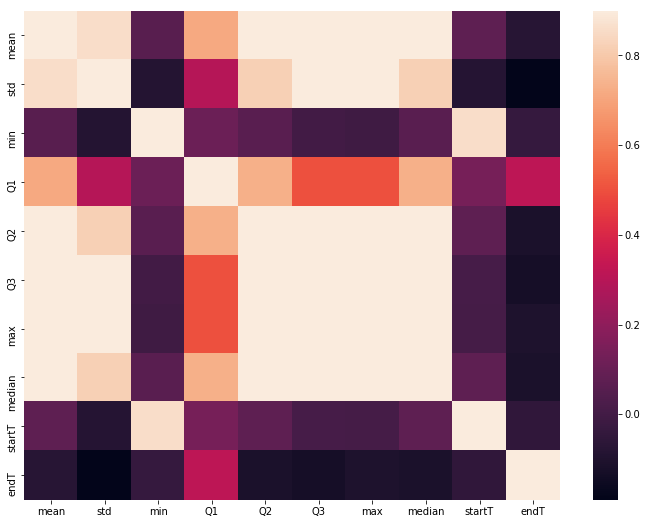

In [15]:
#繪製熱力塗去查看特徵相關性
corrmat = rgdf_data.corr()
plt.subplots(figsize = (12,9))
sns.heatmap(corrmat, vmax = 0.9)

# 模型建立

### 1. KNN Model

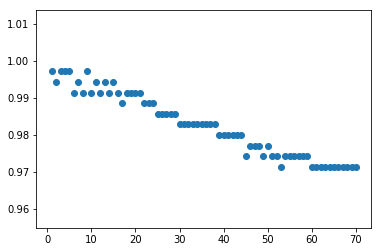

1


In [16]:
#選擇k
accuracies = []
for i in range(1,round(0.05 * train_x.shape[0]) + 1):
    clf = KNeighborsClassifier(n_neighbors = i)
    rg_clf = clf.fit(train_x,train_y)
    test_y_predicted = rg_clf.predict(test_x)
    accuracy = metrics.accuracy_score(test_y,test_y_predicted)
    accuracies.append(accuracy)
#視覺化
plt.scatter(range(1,round(0.05 * train_x.shape[0]) + 1),accuracies)
plt.show()
appr_k = accuracies.index(max(accuracies)) + 1
print(appr_k)    

[48 48 49 49 34 11 48 19 48 48 48 19 34 34 49 34 15 17 49 15 49 19 48 34
 49 19 34 49 17 19 49 19 48 34 48 48 17 32 32 34 34 48 48 15 48 15 32 19
 49 15 48 34 17 34 34 49 32 48 19 34 34 19 49 15 49 15 32 34 34 34 11 19
 49 32 11 15 34 32 15 48 34 34 32 11 19 49 19 48 48 19 32 34 34 11 48 11
 49 32 15 49 32 15 15 34 49 15 34 48 48 19 32 19 48 11 48 34 34 48 49 49
 49 15 49 48 15 15 32 34 34 48 49 34 48 19 49 15 11 11 11 32 15 34 48 34
 32 48 11 19 19 15 11 48 34 34 48 48 49 19 48 15 17 49 11 15 32 15 34 19
 48 34 19 49 49 32 48 48 15 32 19 17 15 34 48 49 48 32 32 48 34 11 48 49
 34 15 15 15 49 49 49 15 15 32 49 15 49 11 34 15 32 49 17 15 49 49 11 32
 48 49 19 15 49 34 49 19 49 19 19 19 19 49 49 34 34 17 19 34 32 32 48 17
 17 48 15 19 32 19 34 17 34 49 19 49 34 49 11 15 11 49 19 48 48 49 49 11
 32 34 34 11 48 19 48 34 11 34 49 15 48 15 15 48 48 19 34 11 15 15 34 48
 15 32 48 34 32 34 49 19 19 49 34 11 19 48 32 34 34 19 11 17 19 19 48 32
 49 11 34 48 19 34 48 34 15 34 32 19 49 19 48 49 11

<Figure size 1600x1280 with 0 Axes>

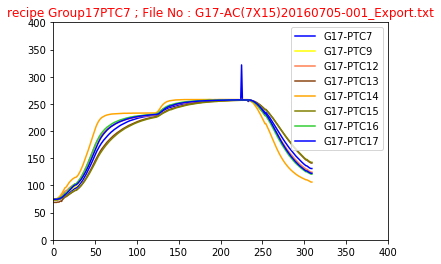

In [17]:
#建立分類器
clf = KNeighborsClassifier(n_neighbors = appr_k)
rg_clf = clf.fit(train_x,train_y)

#預測
test_y_predicted = rg_clf.predict(test_x)
print(test_y_predicted)

#標準答案
print(test_y)

accuracy = metrics.accuracy_score(test_y,test_y_predicted)

print('==============')

print('KNN Model , K = 1, Accuracy Rate = ', accuracy * 100)

print("==============")
for i in range(len(test_y)):
    if test_y[i] != test_y_predicted[i]:
        print(i , ' test_y', test_y[i], '; test_y_predicted', 
              test_y_predicted[i], '; test_data_index', test_x.index[i])
        amisMatchFilePath = myDriveFilePath + 'G'+str(test_y[i]) + '/' + rgdf.loc[rgdf.index[test_x.index[i]] , 'filename']
        misdf = readRecipeGroupFile(amisMatchFilePath)
        plotRecipeGroupFileCurve(misdf,str(test_y[i]) +  rgdf.loc[rgdf.index[test_x.index[i]], 'PTCno']
                                 ,  rgdf.loc[rgdf.index[test_x.index[i]], 'filename'])

In [18]:
knn_model = KNeighborsClassifier(n_neighbors = appr_k)

### 2. SVM模型

In [19]:
C = 1.0  # SVM regularization parameter
svm_model = svm.SVC(kernel='poly', degree=3, C=C, probability=True)

### 3. RandomForestClassifier 模型

In [20]:
rf_model = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.002, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=10, verbose=0, warm_start=False)

### 4. LightGBM 模型

In [21]:
estimator = lightgbm.LGBMClassifier()

param_grid = {
    'learning_rate': [0.01, 0.1, 1],
    'n_estimators': [20, 40,50],
    'max_depth':[3,4,5]
}

gbm = GridSearchCV(estimator, param_grid)

gbm.fit(train_x,train_y)

print('用网格搜索找到的最优超参数为:')
print(gbm.best_params_)

C:\Users\autolab2\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


用网格搜索找到的最优超参数为:
{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}


C:\Users\autolab2\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [22]:
lgb_model =  lightgbm.LGBMClassifier(learning_rate= 0.1,max_depth= 3, n_estimators=50)

### 5. XGBoost Classifier Model 模型

In [23]:
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn import metrics

In [24]:
xgb_model = XGBClassifier(learning_rate=0.01,
                      n_estimators=50,           # 樹的個數-10棵樹建立 xgboost
                      max_depth=5,               # 樹的深度
                      min_child_weight = 1,      # 葉子節點最小權重
                      gamma=0.,                  # 懲罰項中葉子結點個數前的參數
                      subsample=0.8,               # 0.8樣本建立決策樹
                      colsample_btree=0.8,         # 0.8特徵建立決策樹
                      scale_pos_weight=1,        # 解決樣本個數不平衡的問題
                      random_state=27,           # 隨機數
                      slient = 0
                      )
xgb_model.fit(train_x,train_y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_btree=0.8,
       colsample_bylevel=1, colsample_bytree=1, gamma=0.0,
       learning_rate=0.01, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=50, n_jobs=1,
       nthread=None, objective='multi:softprob', random_state=27,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, slient=0, subsample=0.8)

In [25]:
# 預測
test_y, pred_y = test_y, xgb_model.predict(test_x)
print("Accuracy : %.4g" % metrics.accuracy_score(test_y, pred_y)) 

xgb_train_y_proba = xgb_model.predict_proba(train_x)[:,1]
#print("AUC Score (Train): %f" % metrics.roc_auc_score(xgb_train_y, xgb_train_y_proba))

xgb_test_y_proba = xgb_model.predict_proba(test_x)[:,1]
#print("AUC Score (Test): %f" % metrics.roc_auc_score(xgb_test_y, xgb_test_y_proba))

Accuracy : 0.9857


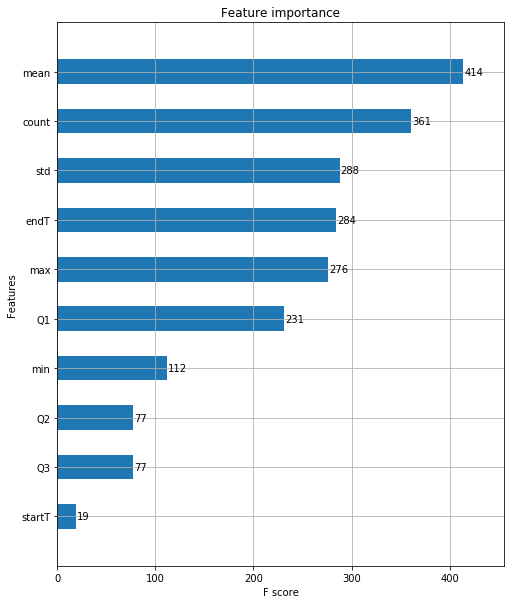

In [26]:
### 特征重要性
fig,ax = plt.subplots(figsize=(8,10))
plot_importance(xgb_model,height=0.5,max_num_features=64,ax=ax)
plt.show()

194  test_y 15 ; test_y_predicted 48 ; test_data_index 167
287  test_y 17 ; test_y_predicted 48 ; test_data_index 429
292  test_y 32 ; test_y_predicted 49 ; test_data_index 938
335  test_y 15 ; test_y_predicted 19 ; test_data_index 148
338  test_y 15 ; test_y_predicted 11 ; test_data_index 150


<Figure size 1600x1280 with 0 Axes>

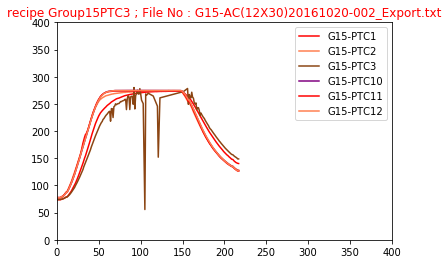

<Figure size 1600x1280 with 0 Axes>

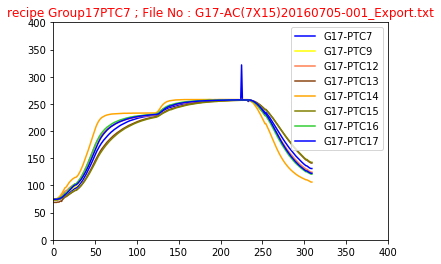

<Figure size 1600x1280 with 0 Axes>

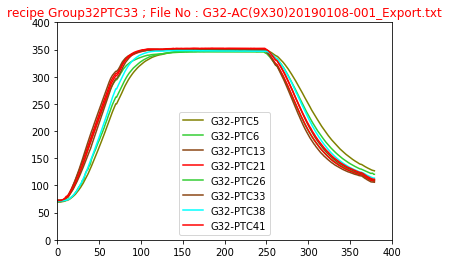

<Figure size 1600x1280 with 0 Axes>

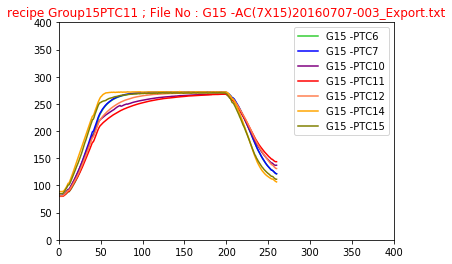

<Figure size 1600x1280 with 0 Axes>

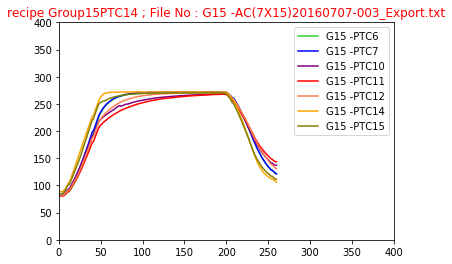

In [27]:
for i in range(len(test_y)):
    if test_y[i] != pred_y[i]:
        print(i , ' test_y', test_y[i], '; test_y_predicted', 
              pred_y[i], '; test_data_index', test_x.index[i])
        amisMatchFilePath = myDriveFilePath + 'G'+ str(test_y[i]) + '/' + rgdf.loc[rgdf.index[test_x.index[i]] , 'filename']
        misdf = readRecipeGroupFile(amisMatchFilePath)
        plotRecipeGroupFileCurve(misdf,str(test_y[i]) +  rgdf.loc[rgdf.index[test_x.index[i]], 'PTCno'],  rgdf.loc[rgdf.index[test_x.index[i]], 'filename'])


In [28]:
from sklearn.ensemble import VotingClassifier

ensembleResult = VotingClassifier(estimators=[('KNN', knn_model), ('XGB', xgb_model), 
                                              ('SVC', svm_model), ('lgb_model', lgb_model), ('RF', rf_model)], 
                                  voting='soft', weights=[1,1,1,1,1], flatten_transform=True)

ensembleResult = ensembleResult.fit(train_x, train_y)

C:\Users\autolab2\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


## 6.Decision Tree

In [29]:
from sklearn.model_selection import GridSearchCV

entropy_thresholds = np.linspace(0, 1, 100)
gini_thresholds = np.linspace(0, 0.2, 100)

dtree_model = tree.DecisionTreeClassifier()

# setup parameter array
param_grid = [{'criterion': ['entropy'], 'min_impurity_decrease': entropy_thresholds},
              {'criterion': ['gini'], 'min_impurity_decrease': gini_thresholds},
              {'max_depth': np.arange(2,10)},
              {'min_samples_split': np.arange(2,30,2)}]

dtree_clf = GridSearchCV(dtree_model, param_grid, cv=5)
dtree_clf.fit(train_x, train_y)
print("best param:{0}\nbest score:{1}".format(dtree_clf.best_params_, dtree_clf.best_score_))

dtree_model = tree.DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=5,
                                          min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0020202, 
                                          max_features=None, random_state=10, max_leaf_nodes=None, 
                                          min_impurity_decrease=0.0, min_impurity_split=None, class_weight=None, presort=False)


best param:{'criterion': 'entropy', 'min_impurity_decrease': 0.0}
best score:0.9871060171919771


C:\Users\autolab2\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


# 7.模型融合

## 7.1 Average-Stacking 

> Stacking模型融合：Average-Stacking
> 簡單的平均基本模型的方法。

In [30]:
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone

In [31]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # 用數據擬合所有的模型
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        for model in self.models_:
            model.fit(X, y)

        return self
    
    # 對結果做average
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)  

In [32]:
averaged_models = AveragingModels(models = (knn_model, svm_model,rf_model, lgb_model,xgb_model))

averaged_models = averaged_models.fit(train_x, train_y)
averaged_predict_y = averaged_models.predict(test_x)
averaged_predict_y = averaged_predict_y.astype(int)
accuracy = metrics.accuracy_score(test_y,averaged_predict_y)

print(" 最集成後的模型的得分: {:.4f} ".format(accuracy))

C:\Users\autolab2\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


 最集成後的模型的得分: 0.9857 


## 7.2 Meta-model Stacking：

Meta-model Stacking： 在這種方法中，我們在平均基礎模型上添加Meta-model，並使用這些基模型的out-of-folds預測來訓練我們的Meta-model。 訓練部分的步驟如下： 1、將整個訓練集分解成兩個不相交的集合（這裡是train和.holdout）。 2、在第一部分（train）上訓練幾個基本模型。 3、在第二個部分（holdout）上測試這些基本模型。 4、使用(3)中的預測（稱為 out-of-fold 預測）作為輸入，並將正確的標籤（目標變量）作為輸出來訓練更高層次的學習模型稱為元模型。 前三個步驟是迭代完成的。例如，如果我們採取5倍的fold，我們首先將訓練數據分成5次。然後我們會做5次迭代。在每次迭代中，我們訓練每個基礎模型4倍，並預測剩餘的fold（holdout fold）。

In [33]:
from sklearn.model_selection import KFold

In [34]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # 用數據擬合所有的模型
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # 得到元模型，並用元模型對out_of_fold做预估，為學習stacking的第2層做數據準備
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # 學習stacking模型
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    # 做stacking预估
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

In [37]:
train_x = train_x.reset_index(drop=True)

In [41]:
stacked_averaged_models = StackingAveragedModels(base_models = (rf_model, lgb_model, xgb_model),
                                                 meta_model = dtree_model)


stacked_averaged_models = stacked_averaged_models.fit(train_x.values, train_y)
stacked_averaged_predict_y = stacked_averaged_models.predict(test_x.values)
stacked_averaged_predict_y = stacked_averaged_predict_y.astype(int)
accuracy = metrics.accuracy_score(test_y,stacked_averaged_predict_y)
print(" 最集成後的模型的得分: {:.4f} ".format(accuracy))

 最集成後的模型的得分: 0.9484 


# Build Model

In [103]:
#### Build Model
classifiers = []

classifiers.append(knn_model)
classifiers.append(dtree_clf)
classifiers.append(svm_model)
classifiers.append(rf_model)
classifiers.append(lgb_model)
classifiers.append(xgb_model)
classifiers.append(averaged_models)
classifiers.append(stacked_averaged_models)


In [61]:
i = 0
for clf in classifiers:
    
    
    if i > 5:
        clf.fit(train_x.values, train_y)
        y_pred= clf.predict(test_x.values)
        y_pred = y_pred.astype(int)
        acc = accuracy_score(test_y, y_pred)
        print("Accuracy of %s is %s" % (clf, acc))
        print('     ')
        cm = confusion_matrix(test_y, y_pred)
        print("Confusion Matrix of %s is " % (clf))
        print(cm)
        print('     ') 
    else:
        clf.fit(train_x, train_y)
        y_pred= clf.predict(test_x)
        acc = accuracy_score(test_y, y_pred)
        print("Accuracy of %s is %s" % (clf, acc))
        print('     ')
        cm = confusion_matrix(test_y, y_pred)
        print("Confusion Matrix of %s is " % (clf))
        print(cm)
        print('     ')
    i += 1
    print('=================================================' ,i)

Accuracy of KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=1, p=2,
           weights='uniform') is 0.997134670487106
     
Confusion Matrix of KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=1, p=2,
           weights='uniform') is 
[[28  0  0  0  0  0  0  0]
 [ 0 49  0  0  0  0  0  0]
 [ 0  0 13  0  0  0  1  0]
 [ 0  0  0 46  0  0  0  0]
 [ 0  0  0  0 33  0  0  0]
 [ 0  0  0  0  0 62  0  0]
 [ 0  0  0  0  0  0 58  0]
 [ 0  0  0  0  0  0  0 59]]
     
================================================= 1


C:\Users\autolab2\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\autolab2\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy of GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'criterion': ['entropy'], 'min_impurity_decrease': array([0.    , 0.0101, ..., 0.9899, 1.    ])}, {'criterion': ['gini'], 'min_impurity_decrease': array([0.     , 0.00202, ..., 0.19798, 0.2    ])}, {'max_depth': array([2, 3, 4, 5, 6, 7, 8, 9])}, {'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28])}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0) is 0.9799426934097422
     
Confusion Matrix of GridSearchCV(

C:\Users\autolab2\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy of AveragingModels(models=(KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=1, p=2,
           weights='uniform'), SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',..._alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, slient=0, subsample=0.8))) is 0.9856733524355301
     
Confusion Matrix of AveragingModels(models=(KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=1, p=2,
           weights='uniform'), SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',..._alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, slient=0, subsample=0.8))) is 
[[28  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  1 47  0  0

## Prediction Exam - 0722 Dataset 36 sample

In [62]:
# exman File 
_logFlag = False
_plotFlag = False
_plotRecipeGroup = 7

examdf = pd.DataFrame(columns=rgColumns)

aExamFileList = getExamFileList()

  
for j in range(len(aExamFileList)):
    edf = readExamFile(aExamFileList[j])
    
    for k in range(len(edf.columns)):
    
        aFileAttributeList = getFileAttributeList(os.path.basename(aExamFileList[j]), False)     

        aPTCno = edf.columns[k].strip()      
        aFileAttributeList.append(aPTCno[aPTCno.find('PTC'): len(aPTCno)])                   #6. PTCno
        aFileAttributeList.append(edf.count()[k])                   #7. count
        aFileAttributeList.append(edf.mean()[k])                    #8. mean
        aFileAttributeList.append(edf.std()[k])                     #9. std
        aFileAttributeList.append(edf.min()[k])                     #10. min
        aFileAttributeList.append(edf.quantile(0.25)[k])            #11. Q1 25%
        aFileAttributeList.append(edf.quantile(0.5)[k])             #12. Q2 50%
        aFileAttributeList.append(edf.quantile(0.75)[k])            #13. Q3 75%
        aFileAttributeList.append(edf.max()[k])                     #14. max
        aFileAttributeList.append(edf.median()[k])                  #15. median
        aFileAttributeList.append(df.loc[1, df.columns[k]])         #16. startT
        aFileAttributeList.append(df.loc[df.count()[k], df.columns[k]])   #17.endT        
        
        
        #aFileAttributeList.append()   #16. start2max_time
        #aFileAttributeList.append()   #17. stable_time
        #aFileAttributeList.append()   #18. max2end_time
        #aFileAttributeList.append()   #19. totaltime

        if j == 0 and _logFlag == True:
            print(aFileAttributeList)

        examdf = examdf.append(pd.DataFrame([aFileAttributeList], columns=rgColumns),ignore_index=True) 

        # plot the same recipe group all file curve
        if i == _plotRecipeGroup and _plotFlag == True:        
            plotRecipeGroupFileCurve(examdf, ' ', aExamFileList[j])
      
examdf.describe()

mean         std         min          Q1          Q2          Q3  \
count  276.000000  276.000000  276.000000  276.000000  276.000000  276.000000   
mean   226.149534   76.509530   75.899638  158.348913  259.369928  295.694203   
std     31.173450   17.101284    9.592677   19.729394   47.302535   43.850275   
min    182.951232   52.018406    0.000000  111.200000  179.500000  247.975000   
25%    202.996052   62.225377   72.875000  158.012500  223.787500  259.668750   
50%    216.629857   69.175375   75.800000  163.325000  249.925000  269.687500   
75%    258.017422   96.275169   79.000000  168.187500  306.325000  349.781250   
max    278.883200  102.596601   99.700000  204.175000  336.100000  356.300000   

              max      median      startT        endT  
count  276.000000  276.000000  276.000000  276.000000  
mean   298.330072  259.369928   75.980797  120.336594  
std     42.924229   47.302535    1.915286    5.721182  
min    249.600000  179.500000   73.300000  113.500000  
25%    264.100000  223.787500   73.700000  114.400000  
50%    271.150000  249.925000   76.000000  117.800000  
75%    350.850000  306.325000   76.600000  123.400000  
max    360.500000  336.100000   80.100000  132.500000

In [63]:
examdf_data = examdf.drop(['filename','groupid','eqpid','PTCno','sno', 'date'], axis = 1)
examdf_data.head(3)

count        mean        std   min       Q1      Q2       Q3    max  median  \
0   236  274.999576  93.706698   0.0  199.600  325.50  354.025  354.4  325.50   
1   236  276.022034  91.630950  73.9  203.450  324.95  354.125  354.4  324.95   
2   236  273.788983  93.750336  72.2  199.675  323.75  354.300  354.7  323.75   

   startT   endT  
0    76.8  113.5  
1    76.0  116.9  
2    73.3  121.9

## get exam predict result Function ()

In [64]:
def genExamResultSummary(aExamdf,aExamPred):
    #define exam result columns name
    
    rangePTCno = np.arange(50)
    examResultColumns = []
    for i in rangePTCno:
        examResultColumns.append(str(rangePTCno[i]))
    
    aExamResultdf = pd.DataFrame(columns = examResultColumns)
    aExamFileList = getExamFileList()
    
    for i in range(len(aExamFileList)):
        
        aExamFileName = os.path.basename(aExamFileList[i])
        aExamResultdf = aExamResultdf.append({'0': aExamFileName}, ignore_index=True)
        
        for j in range(len(aExamdf)):
            if aExamFileName == aExamdf.loc[j,'filename']:
                
                aPTCno = aExamdf.loc[j,'PTCno']
                aPTCno = aPTCno[3:len(aPTCno)]
                
                aExamResultdf.at[i,aPTCno] = aExamPred[j]
    
    return aExamResultdf

  
def genExamResult(aExamResultdf):  
  
  # v1.09

    aPredGroupList = []
    aConfidenceIndexList = []
    rangei = np.arange(aExamResultdf.shape[0])

    for i in rangei:     
  
    # get the predicted group count for each TXT file
        predGroupCount = aExamResultdf.iloc[i, 1:49].nunique()

        if predGroupCount == 1 :
    
            aPredGroupList.append(aExamResultdf.stack().groupby(level=0).apply(lambda x: x.unique().tolist())[i][predGroupCount])
            aConfidenceIndexList.append(1)
        elif predGroupCount > 1 :
            aTotalCount = aExamResultdf.shape[1] - aExamResultdf.apply(lambda row: sum(row[:] != row[:]) ,axis=1)[i] - 1
            maxCount = 0
            maxGroupNo = ''
            rangej = np.arange(predGroupCount)
            for j in rangej:

                aGroupNo = aExamResultdf.stack().groupby(level=0).apply(lambda x: x.unique().tolist())[i][j+1]
                aCount = aExamResultdf.apply(lambda row: sum(row[:]==aGroupNo) ,axis=1)[i]
            if aCount > maxCount:
                maxCount = aCount
                maxGroupNo = aGroupNo
    
            aPredGroupList.append(maxGroupNo)
            aConfidenceIndexList.append(maxCount/aTotalCount)
  
    aExamResultdf['PredictedGroup'] = aPredGroupList  
    aExamResultdf['ConfendenceIndex'] = aConfidenceIndexList  
  
    return aExamResultdf
     

In [75]:
examdf_data.head()

count        mean        std   min       Q1      Q2       Q3    max  \
0    236  274.999576  93.706698   0.0  199.600  325.50  354.025  354.4   
1    236  276.022034  91.630950  73.9  203.450  324.95  354.125  354.4   
2    236  273.788983  93.750336  72.2  199.675  323.75  354.300  354.7   
3    236  274.158475  94.203274  71.8  199.775  324.80  354.400  355.4   
4    236  273.409322  94.807109  71.8  197.725  323.45  354.600  355.9   

   median  startT   endT  
0  325.50    76.8  113.5  
1  324.95    76.0  116.9  
2  323.75    73.3  121.9  
3  324.80    73.7  123.8  
4  323.45    76.1  114.4

In [97]:
#### Predictor
predictor = []

predictor.append(knn_model)
predictor.append(dtree_clf)
predictor.append(svm_model)
predictor.append(rf_model)
predictor.append(lgb_model)
predictor.append(xgb_model)
predictor.append(averaged_models)
predictor.append(stacked_averaged_models)


In [105]:
from sklearn.ensemble import VotingClassifier

_plotPredictFile = False

examdf_data = examdf_data.apply(pd.to_numeric, errors='coerce')                       # str to numeric
examEnsemble = pd.DataFrame()
examEnsembleColumns = ['KNN', 'DT', 'SVM', 'RF', 'LGB', 'XGB','averaged','stacked_averaged_models']

i = 0
for prd, label in zip(classifiers, examEnsembleColumns):
    
    if i <= 6:
        exam_predicted = prd.predict(examdf_data)  
        aExamResultdf = genExamResultSummary(examdf, exam_predicted)
        aExamResultdf = genExamResult(aExamResultdf)
    else:
        exam_predicted = prd.predict(examdf_data.values)  
        exam_predicted = exam_predicted.astype(int)
        aExamResultdf = genExamResultSummary(examdf, exam_predicted)
        aExamResultdf = genExamResult(aExamResultdf)
  
  # plot predict file
  
    if _plotPredictFile == True:
        print(prd, exam_predicted.shape)
        print(exam_predicted)
        print('    ')
        print(aExamResultdf[['0', 'PredictedGroup', 'ConfendenceIndex', '1', '2', '3', '4', '5', '6', '7', '8']])
        print('================================================================================================= ')
        plotPredFile(aExamResultdf,exam_predicted)
    i = i + 1
  
    #examEnsemble[str(i)] = aExamResultdf['PredictedGroup']
    examEnsemble[label] = aExamResultdf['PredictedGroup']

examEnsemble['filename'] = aExamResultdf['0']
print(examEnsemble)

    KNN  DT  SVM  RF  LGB  XGB  Voting  averaged  stacked_averaged_models  \
0    11  11   11  11   11   11      11        11                       11   
1    17  17   17  17   17   17      17        17                       15   
2    19  19   19  19   19   19      19        19                       19   
3    19  19   19  19   19   19      19        19                       19   
4    49  32   32  32   32   32      32        35                       32   
5    32  32   32  32   32   32      32        32                       32   
6    32  32   32  32   32   32      32        32                       32   
7    32  32   32  32   32   32      32        32                       32   
8    32  32   32  32   32   32      32        32                       32   
9    49  32   32  32   32   32      32        35                       32   
10   34  48   34  34   48   34      34        36                       34   
11   11  11   11  11   11   11      11        11                       11   

In [106]:
examEnsemble['value'] = examEnsemble.apply(lambda x:x.mode(),axis = 1)

In [81]:
examEnsemble.rename(columns = {0:'knn_model',1:'svm_model',2:'rf_model',3:'lgb_model',
                               4:'xgb_model','0':'filename','value':'Final_Result'},inplace = True)

In [107]:
examEnsemble.index = examEnsemble['filename'].apply(lambda x: int(re.search( r'(\d{1,2})',x).group()))

In [108]:
examEnsemble = examEnsemble.sort_index()

In [109]:
examEnsemble

KNN  DT  SVM  RF  LGB  XGB  Voting  averaged  \
filename                                                 
1          11  11   11  11   11   11      11        11   
2          11  11   11  11   11   11      11        11   
3          15  15   15  15   15   15      15        15   
4          15  15   15  15   15   15      15        15   
5          15  15   15  15   15   15      15        15   
6          15  15   15  15   15   15      15        15   
7          15  15   15  15   15   15      15        15   
8          15  15   15  15   15   15      15        15   
9          17  17   17  17   17   17      17        17   
10         17  17   17  17   17   17      17        17   
11         19  19   19  19   19   19      19        19   
12         19  19   19  19   19   19      19        19   
13         49  32   32  32   32   32      32        35   
14         32  32   32  32   32   32      32        32   
15         32  32   32  32   32   32      32        32   
16         32  32   32  32   32   32      32        32   
17         32  32   32  32   32   32      32        32   
18         49  32   32  32   32   32      32        35   
19         34  48   34  34   48   34      34        36   
20         34  48   34  34   48   34      34        36   
21         34  48   34  34   48   34      34        36   
22         34  48   34  34   48   34      34        36   
23         34  48   34  34   48   34      34        36   
24         34  48   34  34   48   34      34        36   
25         48  48   48  48   48   48      48        48   
26         48  48   48  48   48   48      48        48   
27         48  48   17  48   48   48      48        48   
28         48  48   48  48   48   48      48        48   
29         48  48   48  48   48   48      48        48   
30         48  48   48  48   48   48      48        48   
31         49  49   49  49   49   49      49        49   
32         49  49   49  49   49   49      49        49   
33         49  49   49  49   49   49      49        49   
34         49  49   49  49   49   49      49        49   
35         49  49   49  49   49   49      49        49   
36         49  49   49  49   49   49      49        49   

          stacked_averaged_models filename  value  
filename                                           
1                              11    1.txt     11  
2                              11    2.txt     11  
3                              15    3.txt     15  
4                              15    4.txt     15  
5                              15    5.txt     15  
6                              15    6.txt     15  
7                              15    7.txt     15  
8                              15    8.txt     15  
9                              15    9.txt     17  
10                             15   10.txt     17  
11                             19   11.txt     19  
12                             19   12.txt     19  
13                             32   13.txt     32  
14                             32   14.txt     32  
15                             32   15.txt     32  
16                             32   16.txt     32  
17                             32   17.txt     32  
18                             32   18.txt     32  
19                             34   19.txt     34  
20                             34   20.txt     34  
21                             34   21.txt     34  
22                             34   22.txt     34  
23                             34   23.txt     34  
24                             34   24.txt     34  
25                             19   25.txt     48  
26                             32   26.txt     48  
27                             19   27.txt     48  
28                             19   28.txt     48  
29                             32   29.txt     48  
30                             48   30.txt     48  
31                             49   31.txt     49  
32                             49   32.txt     49  
33                             49   3

In [84]:
examEnsemble.to_csv('examResultv3.csv')

In [115]:

# define exam result columns name   
rangePTCno = np.arange(50)

examResultColumns = []

for i in rangePTCno:
  
  examResultColumns.append(str(rangePTCno[i]))
  
#print(examResultColumns)



# prepare exam result table

examResultdf = pd.DataFrame(columns=examResultColumns)

aExamFileList = getExamFileList()

rangei = np.arange(len(aExamFileList))

for i in rangei:     
    
    aexamFileName = os.path.basename(aExamFileList[i])
    examResultdf = examResultdf.append({'0': aexamFileName}, ignore_index=True)
  
    rangej = np.arange(len(examdf)) 
    
    for j in rangej:
    
        if aexamFileName == examdf.loc[j, 'filename']:
      
            aPTCno = examdf.loc[j, 'PTCno']
      
            aPTCno = aPTCno[3:len(aPTCno)]
       
            examResultdf.at[i, aPTCno] = exam_predicted[i]
 
      
examResultdf.head(3)



0   1   2   3   4   5    6    7    8    9 ...    40   41   42   43  \
0   1.txt  11  11  11  11  11  NaN  NaN  NaN  NaN ...   NaN  NaN  NaN  NaN   
1  10.txt  11  11  11  11  11   11   11   11  NaN ...   NaN  NaN  NaN  NaN   
2  11.txt  11  11  11  11  11   11   11   11  NaN ...   NaN  NaN  NaN  NaN   

    44   45   46   47   48   49  
0  NaN  NaN  NaN  NaN  NaN  NaN  
1  NaN  NaN  NaN  NaN  NaN  NaN  
2  NaN  NaN  NaN  NaN  NaN  NaN  

[3 rows x 50 columns]

C:\Users\autolab2\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<Figure size 1600x1280 with 0 Axes>

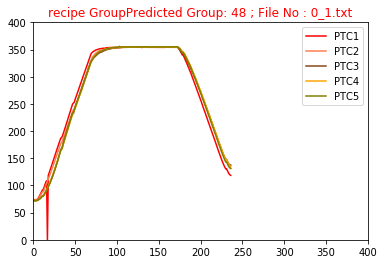

<Figure size 1600x1280 with 0 Axes>

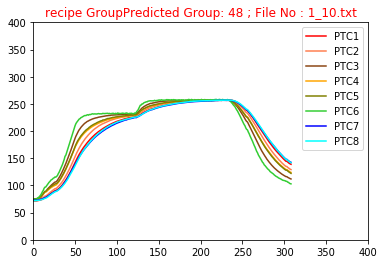

<Figure size 1600x1280 with 0 Axes>

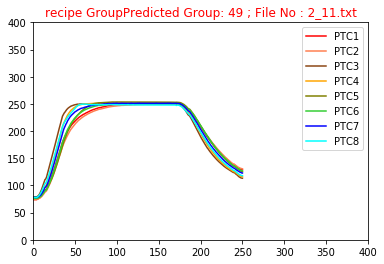

<Figure size 1600x1280 with 0 Axes>

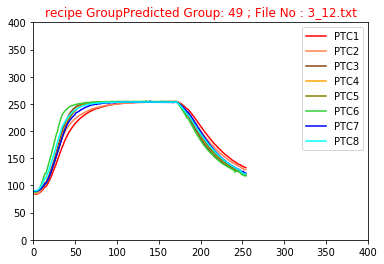

<Figure size 1600x1280 with 0 Axes>

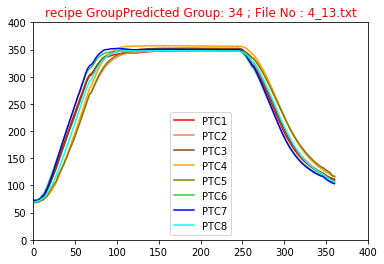

<Figure size 1600x1280 with 0 Axes>

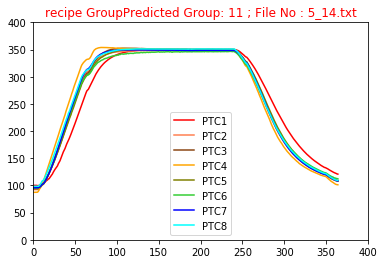

<Figure size 1600x1280 with 0 Axes>

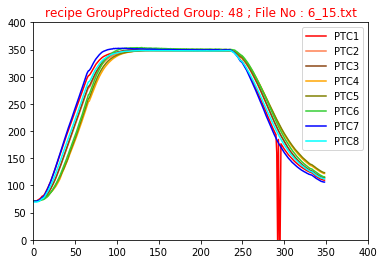

<Figure size 1600x1280 with 0 Axes>

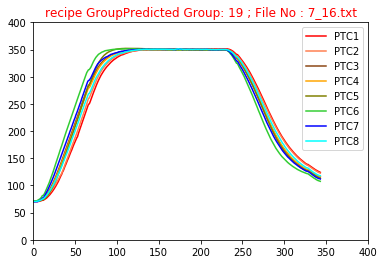

<Figure size 1600x1280 with 0 Axes>

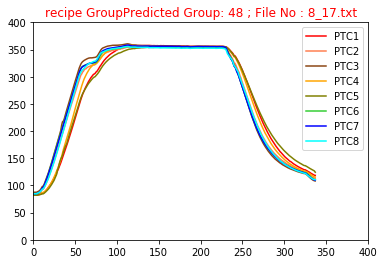

<Figure size 1600x1280 with 0 Axes>

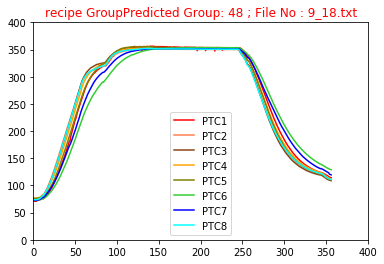

<Figure size 1600x1280 with 0 Axes>

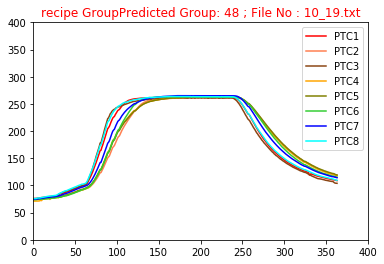

<Figure size 1600x1280 with 0 Axes>

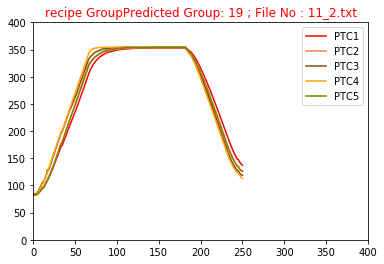

<Figure size 1600x1280 with 0 Axes>

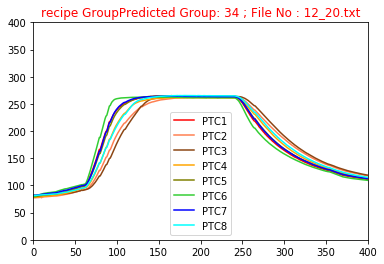

<Figure size 1600x1280 with 0 Axes>

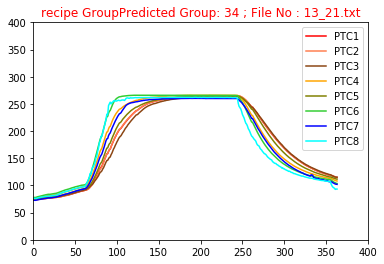

<Figure size 1600x1280 with 0 Axes>

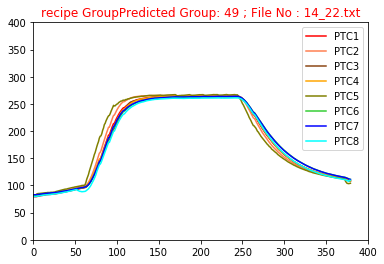

<Figure size 1600x1280 with 0 Axes>

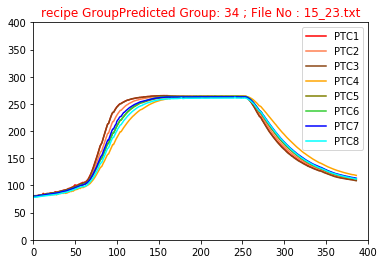

<Figure size 1600x1280 with 0 Axes>

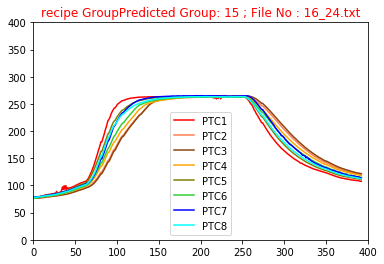

<Figure size 1600x1280 with 0 Axes>

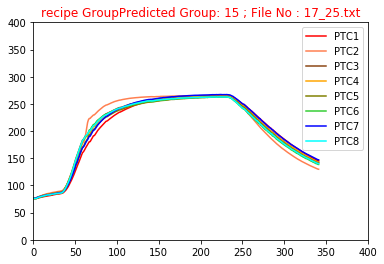

<Figure size 1600x1280 with 0 Axes>

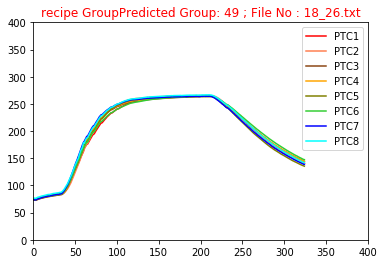

<Figure size 1600x1280 with 0 Axes>

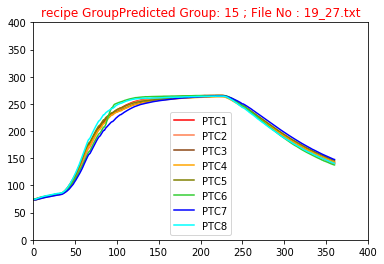

<Figure size 1600x1280 with 0 Axes>

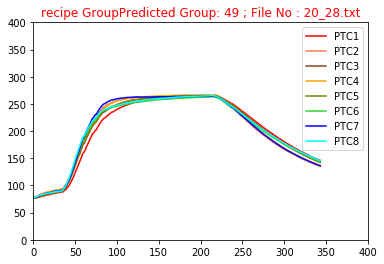

<Figure size 1600x1280 with 0 Axes>

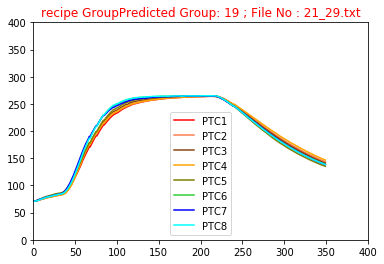

<Figure size 1600x1280 with 0 Axes>

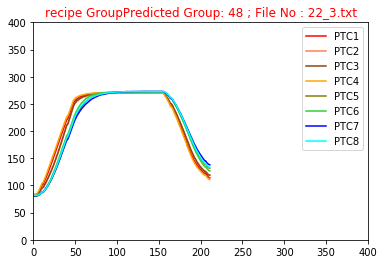

<Figure size 1600x1280 with 0 Axes>

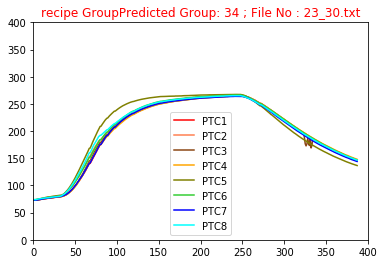

<Figure size 1600x1280 with 0 Axes>

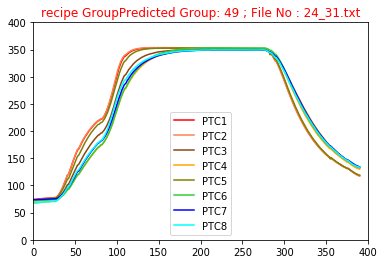

<Figure size 1600x1280 with 0 Axes>

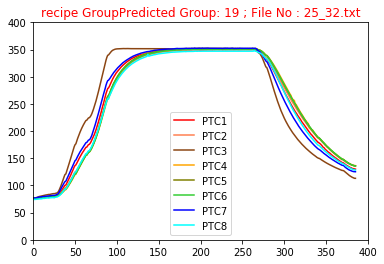

<Figure size 1600x1280 with 0 Axes>

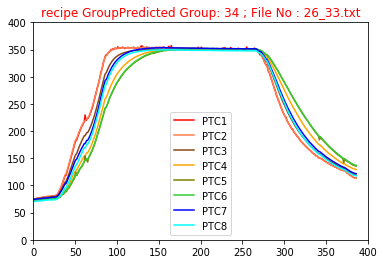

<Figure size 1600x1280 with 0 Axes>

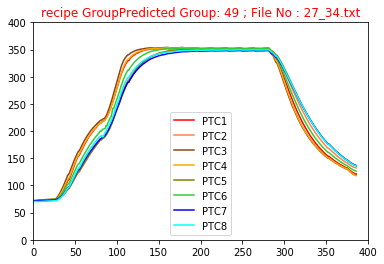

<Figure size 1600x1280 with 0 Axes>

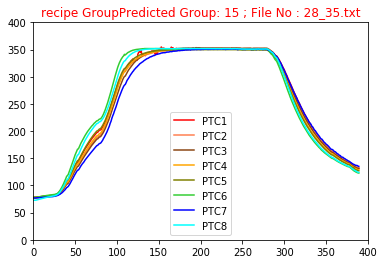

<Figure size 1600x1280 with 0 Axes>

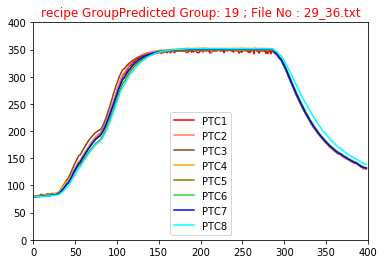

<Figure size 1600x1280 with 0 Axes>

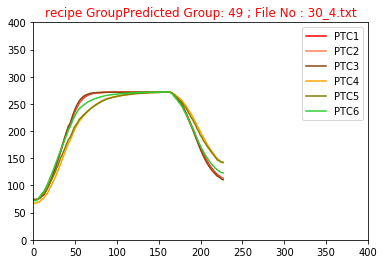

<Figure size 1600x1280 with 0 Axes>

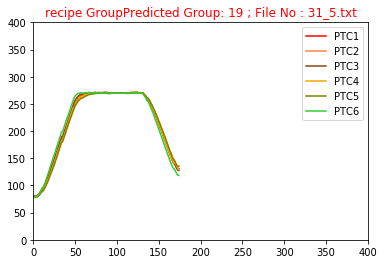

<Figure size 1600x1280 with 0 Axes>

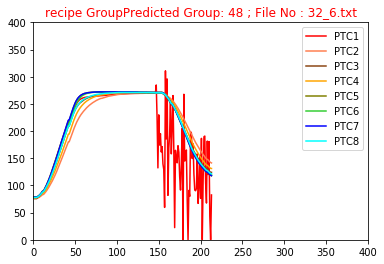

<Figure size 1600x1280 with 0 Axes>

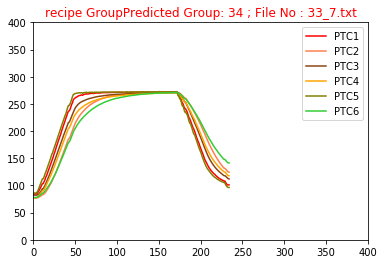

<Figure size 1600x1280 with 0 Axes>

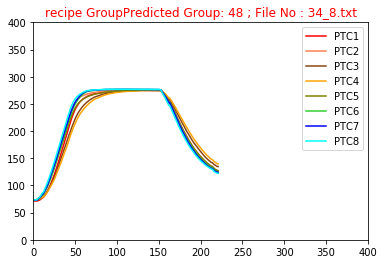

<Figure size 1600x1280 with 0 Axes>

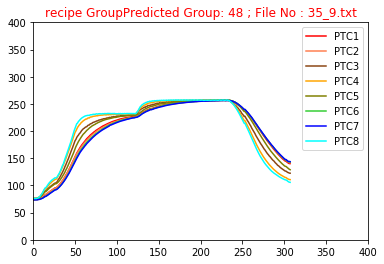

In [122]:
 #@title 默认标题文本 { vertical-output: true }
 rangei = np.arange(len(examResultdf))

for i in rangei:
  
   # plot predict file
    edf = readExamFile(examFilePath + examResultdf.at[i,'0'])
    plotRecipeGroupFileCurve(edf, 'Predicted Group: ' + str(stacked_averaged_predict_y[i]), str(i) + '_' + examResultdf.at[i,'0'])
